# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing as p
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv",delimiter=";")

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv",delimiter=";")

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print("AZDIAS dataframe size\nrows: {}\ncols: {}".format(*azdias.shape))

AZDIAS dataframe size
rows: 891221
cols: 85


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [4]:
# let's start by analysing features data set collumns
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [5]:
for col in feat_info.columns.values:
    print(col + "\n")
    print("Unique values: {}".format(getattr(feat_info, col).unique()))
    print("No. of unique values: {}".format(getattr(feat_info, col).nunique()))
    print("_"*90)

attribute

Unique values: ['AGER_TYP' 'ALTERSKATEGORIE_GROB' 'ANREDE_KZ' 'CJT_GESAMTTYP'
 'FINANZ_MINIMALIST' 'FINANZ_SPARER' 'FINANZ_VORSORGER' 'FINANZ_ANLEGER'
 'FINANZ_UNAUFFAELLIGER' 'FINANZ_HAUSBAUER' 'FINANZTYP' 'GEBURTSJAHR'
 'GFK_URLAUBERTYP' 'GREEN_AVANTGARDE' 'HEALTH_TYP' 'LP_LEBENSPHASE_FEIN'
 'LP_LEBENSPHASE_GROB' 'LP_FAMILIE_FEIN' 'LP_FAMILIE_GROB'
 'LP_STATUS_FEIN' 'LP_STATUS_GROB' 'NATIONALITAET_KZ'
 'PRAEGENDE_JUGENDJAHRE' 'RETOURTYP_BK_S' 'SEMIO_SOZ' 'SEMIO_FAM'
 'SEMIO_REL' 'SEMIO_MAT' 'SEMIO_VERT' 'SEMIO_LUST' 'SEMIO_ERL'
 'SEMIO_KULT' 'SEMIO_RAT' 'SEMIO_KRIT' 'SEMIO_DOM' 'SEMIO_KAEM'
 'SEMIO_PFLICHT' 'SEMIO_TRADV' 'SHOPPER_TYP' 'SOHO_KZ' 'TITEL_KZ'
 'VERS_TYP' 'ZABEOTYP' 'ALTER_HH' 'ANZ_PERSONEN' 'ANZ_TITEL'
 'HH_EINKOMMEN_SCORE' 'KK_KUNDENTYP' 'W_KEIT_KIND_HH' 'WOHNDAUER_2008'
 'ANZ_HAUSHALTE_AKTIV' 'ANZ_HH_TITEL' 'GEBAEUDETYP' 'KONSUMNAEHE'
 'MIN_GEBAEUDEJAHR' 'OST_WEST_KZ' 'WOHNLAGE' 'CAMEO_DEUG_2015'
 'CAMEO_DEU_2015' 'CAMEO_INTL_2015' 'KBA05_ANTG1' 'KBA05_ANTG2

In [6]:
# it seems that some features don't have specifict notation for missing or unknow data, i.e. missing_or_unknown collumn contains '[]' value
print("There are {} such [] features.".format(feat_info[feat_info.missing_or_unknown == '[]'].index.size))

There are 10 such [] features.


In [7]:
print("Attribute                 | No. of nan")
print("_"*40)
for a in feat_info[feat_info.missing_or_unknown == '[]'].attribute:
    print("{:25s} | {}".format(a, azdias[a].isnull().sum()))

Attribute                 | No. of nan
________________________________________
GFK_URLAUBERTYP           | 4854
GREEN_AVANTGARDE          | 0
ANZ_PERSONEN              | 73499
ANZ_TITEL                 | 73499
ANZ_HH_TITEL              | 97008
KONSUMNAEHE               | 73969
GEBAEUDETYP_RASTER        | 93155
MOBI_REGIO                | 133324
ONLINE_AFFINITAET         | 4854
KBA13_ANZAHL_PKW          | 105800


In [8]:
# Now lets review all features and their missing_or_unkown collumn
print("[FEATURE]                 | Missing or unknown")
print("-"*46)
for idx in feat_info.index:
    print("{:25s}   {}".format(feat_info.iloc[idx].attribute,feat_info.iloc[idx].missing_or_unknown))

[FEATURE]                 | Missing or unknown
----------------------------------------------
AGER_TYP                    [-1,0]
ALTERSKATEGORIE_GROB        [-1,0,9]
ANREDE_KZ                   [-1,0]
CJT_GESAMTTYP               [0]
FINANZ_MINIMALIST           [-1]
FINANZ_SPARER               [-1]
FINANZ_VORSORGER            [-1]
FINANZ_ANLEGER              [-1]
FINANZ_UNAUFFAELLIGER       [-1]
FINANZ_HAUSBAUER            [-1]
FINANZTYP                   [-1]
GEBURTSJAHR                 [0]
GFK_URLAUBERTYP             []
GREEN_AVANTGARDE            []
HEALTH_TYP                  [-1,0]
LP_LEBENSPHASE_FEIN         [0]
LP_LEBENSPHASE_GROB         [0]
LP_FAMILIE_FEIN             [0]
LP_FAMILIE_GROB             [0]
LP_STATUS_FEIN              [0]
LP_STATUS_GROB              [0]
NATIONALITAET_KZ            [-1,0]
PRAEGENDE_JUGENDJAHRE       [-1,0]
RETOURTYP_BK_S              [0]
SEMIO_SOZ                   [-1,9]
SEMIO_FAM                   [-1,9]
SEMIO_REL                   [-1,9]
SEMIO_MA

Fuction bellow will use `feat_info` collumn "missing_or_unknown" data to replace `azdias` dataframe's missing or known values with numpy NAN.

In [9]:
def remove_nan(main_df, feat_df):
    """
    Identify missing or unknown data values and convert them to NaNs.
    """
    for idx in feat_df.index:
        # collumn name
        col_n = feat_df.iloc[idx].attribute
        # missing or unknow values for that collumn. Convert string to list
        m_u = feat_df.iloc[idx].missing_or_unknown[1:-1].split(',')
        # replace/convert values for those collumn/features, whose m_u value is empty list
        if m_u != [""]:
            # convert values in the list to appropreate data type
            # first get data dype of feture collum
            # >> azdias[col_n].dtypes
            # then convert list to np array
            m_u = np.array(m_u, dtype=main_df[col_n].dtypes)
            # replace any values in m_u array with np.nan
            main_df[col_n] = main_df[col_n].replace(m_u, np.nan)
    return main_df

In [10]:
# azdias dataframe with converted NAN values
azdias_mod_1 = remove_nan(azdias, feat_info)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [11]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# get collumn name array
col_names = azdias_mod_1.columns.values
# count NAN values in each collumn
nan_values = azdias_mod_1.isnull().sum().values
# count procentage of each nan value
nan_values_poc = nan_values / azdias_mod_1.shape[0] * 100

In [12]:
print("Total missing datapoints: {}".format(np.sum(azdias_mod_1.isnull().sum().values)))
print("{:.2f} % of all data missing".format(100*np.sum(azdias_mod_1.isnull().sum().values) / (azdias_mod_1.shape[0] * azdias_mod_1.shape[1])))

Total missing datapoints: 8373929
11.05 % of all data missing


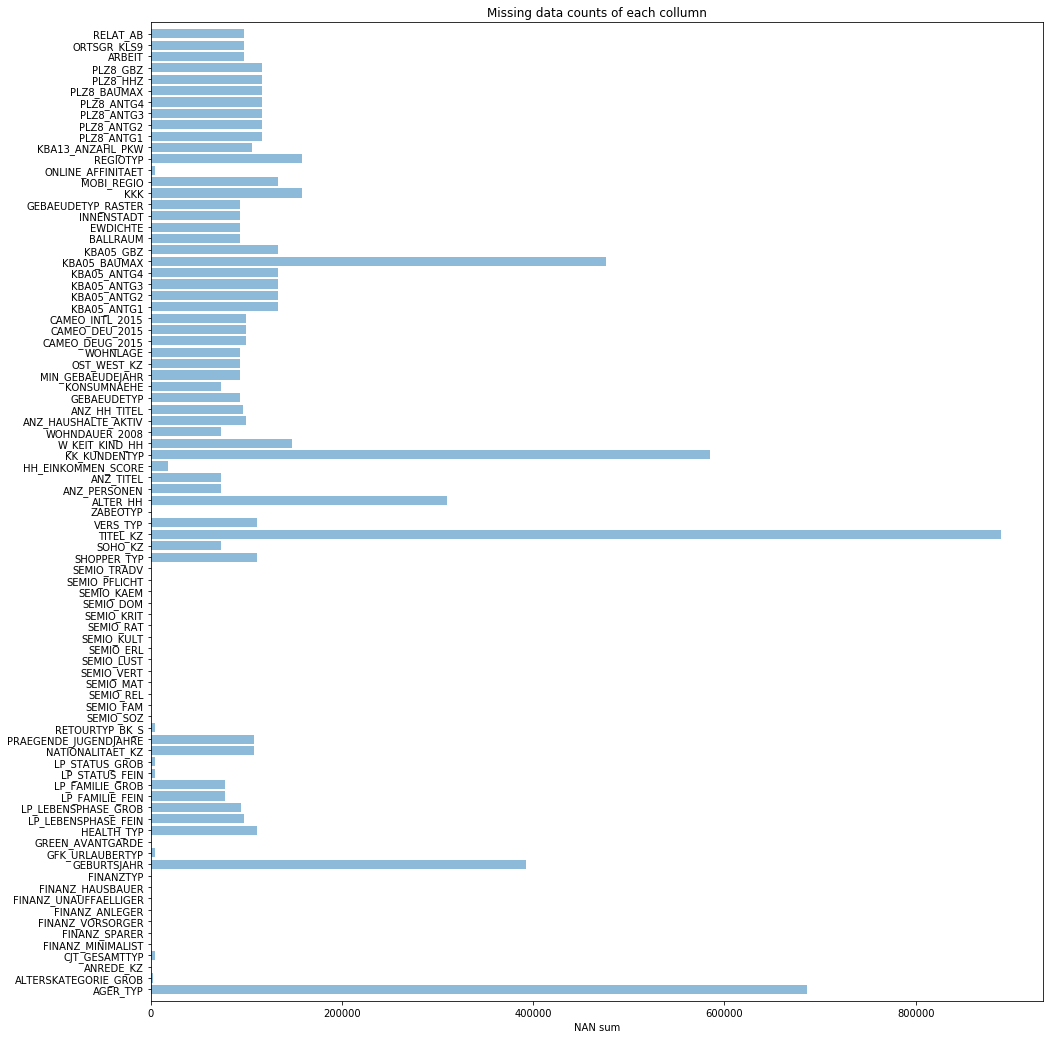

In [13]:
plt.figure(figsize=(16,18))

y_pos = np.arange(len(col_names))
plt.barh(y_pos, nan_values, align='center', alpha=0.5)
plt.yticks(y_pos, col_names)
plt.ylim(-1,85)
plt.xlabel('NAN sum')
plt.title('Missing data counts of each collumn')
 
plt.show()

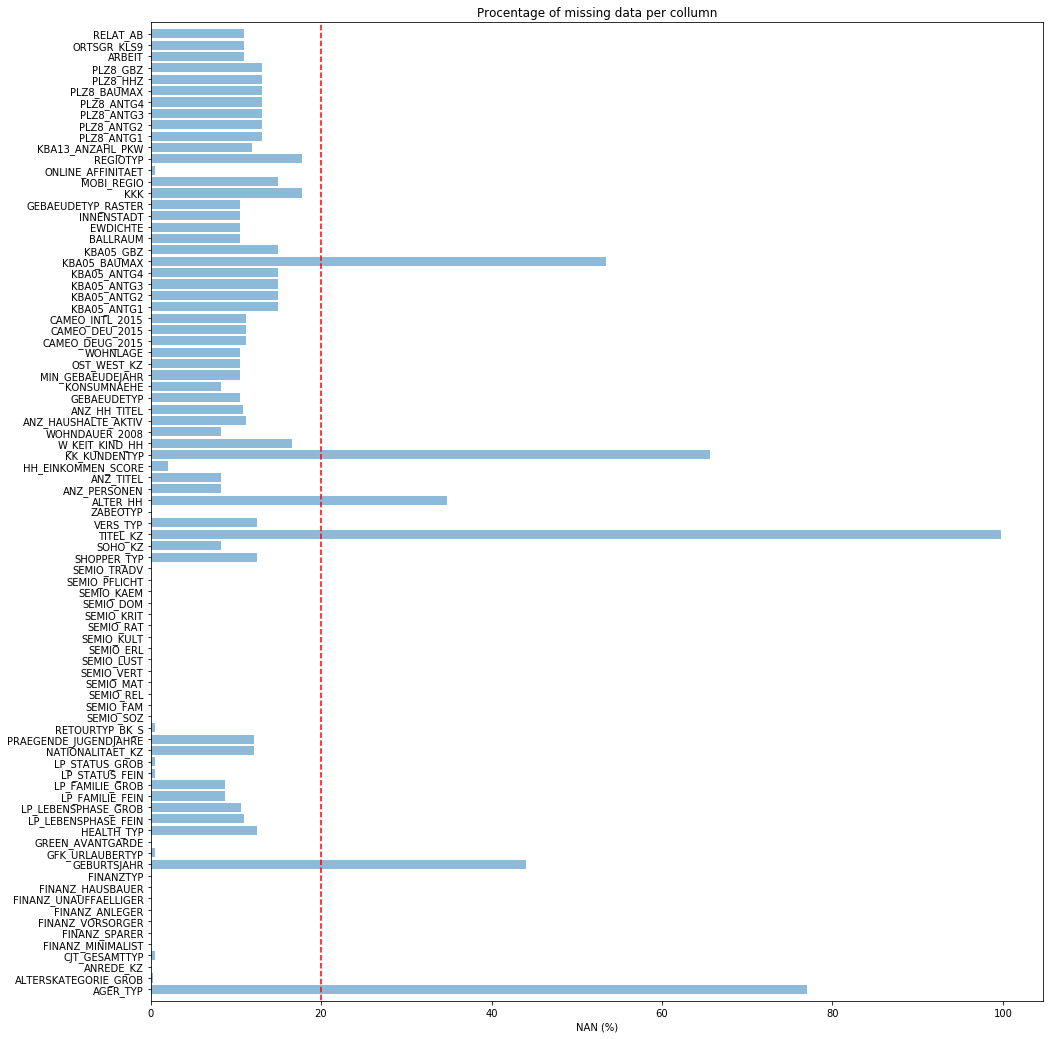

In [14]:
# Investigate patterns in the amount of missing data in each column.

plt.figure(figsize=(16,18))

y_pos = np.arange(len(col_names))
plt.barh(y_pos, nan_values_poc, align='center', alpha=0.5)
# visually show which features have more than 20% of missing data
plt.plot([20,20],[-5,85],"r--")
plt.ylim(-1,85)
plt.yticks(y_pos, col_names)
plt.xlabel('NAN (%)')
plt.title('Procentage of missing data per collumn')
 
plt.show()

In [15]:
print("TITEL_KZ has {:.2f} % missing data".format(azdias_mod_1.TITEL_KZ.isnull().sum() / azdias_mod_1.shape[0] * 100))

TITEL_KZ has 99.76 % missing data


There is one feature `TITEL_KZ` (Academic title flag) which has ~100% missing data. In addition, from visual inspection, it seems that were are 6 features in total which have more than 20% of missing data. Thus I will continue with data processing by dropping these 6 features fromd ataset.

In [16]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

def remove_nan_collumns(df, limit= 0.2):
    """
    Returns a new dataframe without collumns which had more than LIMIT missing data
    """

    no_of_rows = df.shape[0]

    for col_name in df.columns.values:
        # count how many missing values in collumn
        no_of_missing_values = df[col_name].isnull().sum()
        if no_of_missing_values > no_of_rows * limit:
            df = df.drop([col_name], axis=1)
            miss_proc = (no_of_missing_values / no_of_rows) * 100
            print("{:15s} feature removed, {:.2f} % missing data".format(col_name, miss_proc))
            
    return df

In [17]:
azdias_mod_2 = remove_nan_collumns(azdias_mod_1)

AGER_TYP        feature removed, 76.96 % missing data
GEBURTSJAHR     feature removed, 44.02 % missing data
TITEL_KZ        feature removed, 99.76 % missing data
ALTER_HH        feature removed, 34.81 % missing data
KK_KUNDENTYP    feature removed, 65.60 % missing data
KBA05_BAUMAX    feature removed, 53.47 % missing data


In [18]:
print("after removing collumns with >20% of missing data")
print("{:.2f} % of all remaing data is missing".format(100*np.sum(azdias_mod_2.isnull().sum().values) / (azdias_mod_2.shape[0] * azdias_mod_2.shape[1])))

after removing collumns with >20% of missing data
7.15 % of all remaing data is missing


#### Discussion 1.1.2: Assess Missing Data in Each Column

* Prior removing collumns 11.05 % of `Udacity_AZDIAS_Subset.csv` data was missing or unknown.
* After removing collumns nly 7.15 % of total `Udacity_AZDIAS_Subset.csv` data is missing or unknown.
* First using `AZDIAS_Feature_Summary.csv` missing_or_unknown collumn, main data were relabeled to np.nan.
* Then NAN values were counted at each collumn.
* From visual analysis (barchart NAN data count vs collumn name) 6 collumns stood out with a lot of missing data. Hence it was chosen to remove collumns with more than 20% of missing data
* Remvoed collumns were:
    * AGER_TYP (Best-ager typology), person's age I think gives you more meaningful info than his age typology
    * GEBURTSJAHR (Year of birth) This should be considered as important piece of information
    * TITEL_KZ (Academic title) If you don't have any data, you can safely drop this feature.
    * ALTER_HH (Birthdate of head of household) This might be an important feature to maintain, in order to test, whatever purcases are influanced by the head of household.
    * KK_KUNDENTYP (Consumer pattern over past 12 months) This should be important feature and shouldn't be removed event if ~65% data is missing
    * KBA05_BAUMAX (Most common building type within the microcell) It is hard to tell how importatnt is the size of family.
    
* After reviewing these features I decided to extend my will to  <font color="red">66%</font> so that important features like  GEBURTSJAHR and KK_KUNDENTYP wouldn't be removed. After such procdure, 9.19% data is missing (~2% improvement by removing just too collumns).

In [19]:
azdias_mod_2 = remove_nan_collumns(azdias_mod_1, limit= 0.66)

AGER_TYP        feature removed, 76.96 % missing data
TITEL_KZ        feature removed, 99.76 % missing data


In [20]:
print("after removing collumns with >66% of missing data")
print("{:.2f} % of all remaing data is missing".format(100*np.sum(azdias_mod_2.isnull().sum().values) / (azdias_mod_2.shape[0] * azdias_mod_2.shape[1])))

after removing collumns with >66% of missing data
9.19 % of all remaing data is missing


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [21]:
# How much data is missing in each row of the dataset?

# create new colllumn which counts how much data is per each row.
# This collumn will allow us to apply filters on our dataframe
azdias_mod_2["data_count_per_row"] = azdias_mod_2.apply(lambda x: x.count(), axis=1)

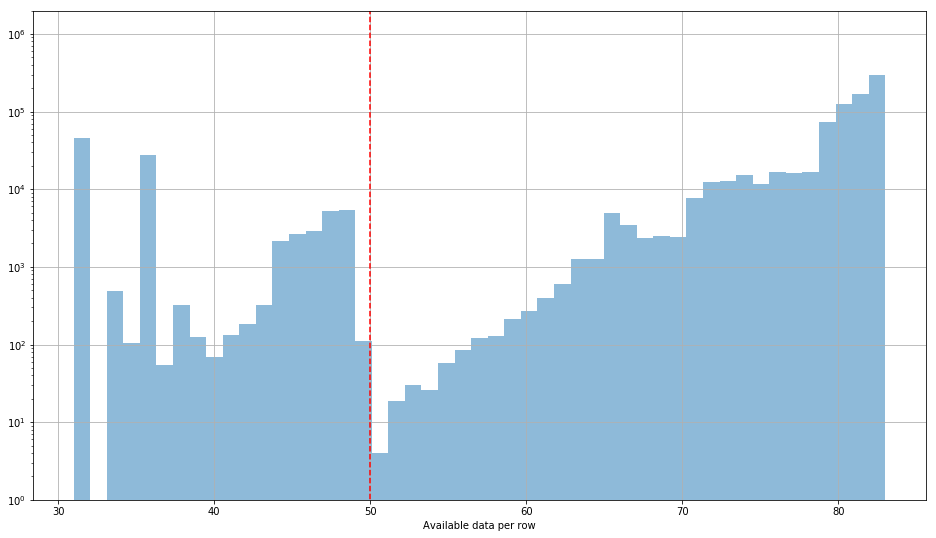

In [22]:
plt.figure(figsize=(16,9))
# I calculated that range between min and max is 49, thus bins= 49 was used
azdias_mod_2["data_count_per_row"].hist(bins=49, log=True, alpha=0.5);
plt.xlabel("Available data per row");
plt.plot([50, 50],[0, 2e6],"r--");
plt.ylim(1,2e6);

From Histogram above one can observe two data blocks which are "roughtly" separated around 50 (indicated with red dashed line). When applying filter on rows, I will create new collumn indicating LEFT (available data <= 50) and RIGHT (available data > 50)

In [23]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# add additional collumn which tells whatever the available data per row is above or below 48
# Then with map I rename True and False to LEFT (<=48) and RIGHT (>48)
azdias_mod_2["data_split"] = (azdias_mod_2["data_count_per_row"] <= 50).map({True: "<=48", False: ">48"})
azdias_mod_2.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,data_count_per_row,data_split
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36,<=48
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,81,>48
2,3.0,2,3.0,1,4,1,2,3,5,1,...,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,81,>48
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,75,>48
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,82,>48


In [24]:
def plot_multiple_countplots(df, log=False):
    """
    Helper function to plot all collumns using seaborns count plot
    
    Skips last two collumns and generates required subplots
    """
    fig, axes = plt.subplots(nrows=int(np.ceil(df.columns.values[:-2].shape[0]/2)), ncols=2, figsize=(16,250))
    collumn_names = df.columns.values[:-2]
    for ax, name in zip(axes.flatten(),collumn_names):
        sns.countplot(x=name, hue="data_split", data=df, ax=ax, log=log)

C:\Users\Tomas\PycharmProjects\nano_degree_DS\venv\lib\site-packages\matplotlib\axes\_base.py:3443: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))


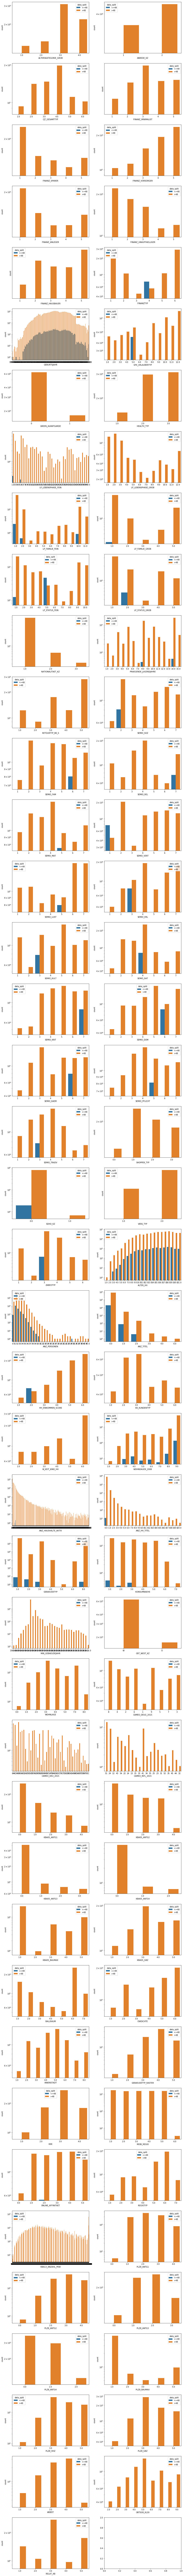

In [25]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

plot_multiple_countplots(azdias_mod_2, log=True)

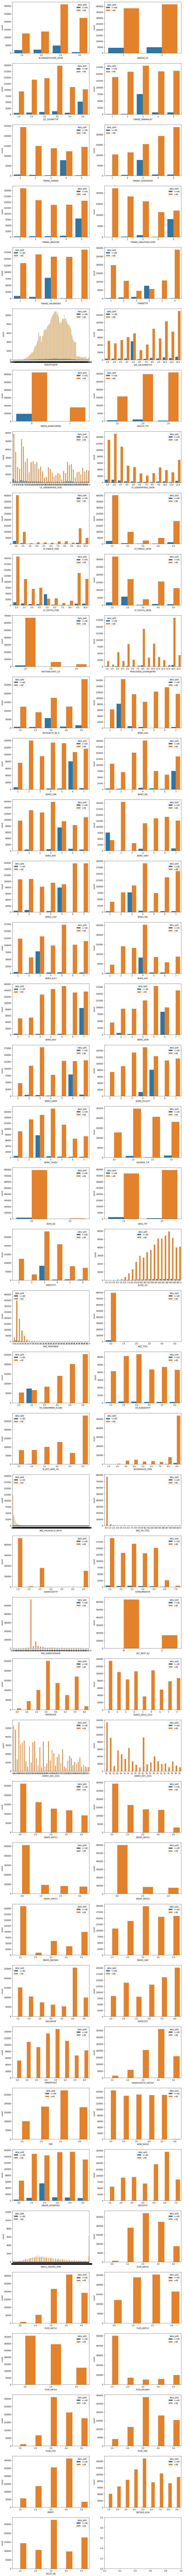

In [26]:
plot_multiple_countplots(azdias_mod_2)

In [27]:
# plot and save individual figures for discussion
# sns.countplot(x="ANZ_HH_TITEL", hue="data_split", data=azdias_mod, log=False);
# plt.savefig(fname= "ANZ_HH_TITEL.png", format="png")

#### Discussion 1.1.3: Assess Missing Data in Each Row

By ploting histogram of "no of available data points per row" in log scale revealed 2 groups of points, which could be spearated into two ranges (0-48) and (49-79). By plotting countplots of each collumn, I found some features wich are quantitevelly different with different no. of available data. Few examples are shown bellow: 

### One single value vs a distribution
This is an example, when rows with less data have only single data point, while rows with more data points have left of right skewed distributions.

<table><tr><td><img src='ZABEOTYP.png'></td><td><img src='GFK_URLAUBERTYP.png'></td></tr></table>

Sometimes rows with less data can have only two or three values present out of all available values.

<table><tr><td><img src='LP_STATUS_FEIN.png'></td><td><img src='LP_FAMILIE_FEIN.png'></td></tr></table>

### Empty features
There are quite a few collumns/features that doesn't seem to have any values if row of interest has less than 48 data points.

<table><tr><td><img src='CAMEO_INTL_2015.png'></td><td><img src='KBA05_ANTG4.png'></td></tr></table>


### Single dominant value
There are collumns/features which of all available data has only one.

<table><tr><td><img src='ANZ_HH_TITEL.png'></td><td><img src='ANZ_TITEL.png'></td></tr></table>

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

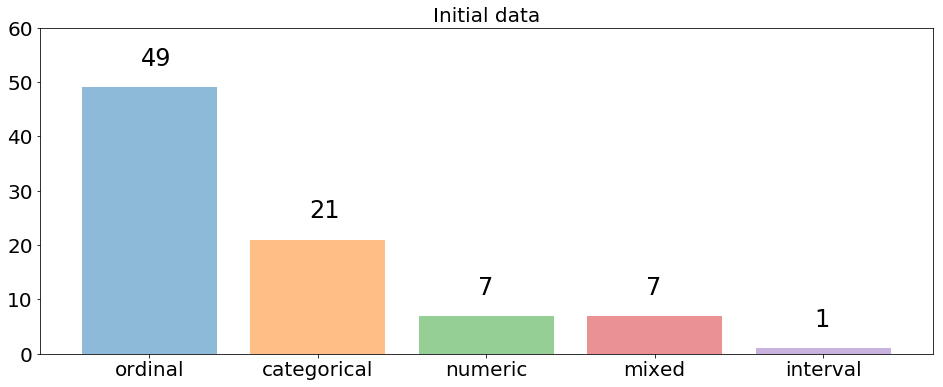

In [28]:
# How many features are there of each data type?

s = feat_info['type'].value_counts()


# plt.figure(figsize=(16,6))
ax = s.plot.bar(width=.8, alpha=0.5, figsize=(16,6)) 
ax.set_ylim(0,60)

# draw counts
for i, v in s.reset_index().iterrows():
    ax.text(i-0.05, v.type + 4 , v.type, fontsize= 24)
    

plt.title("Initial data", fontsize= 20)
plt.xticks(rotation=0, fontsize= 20);
plt.yticks(fontsize= 20);

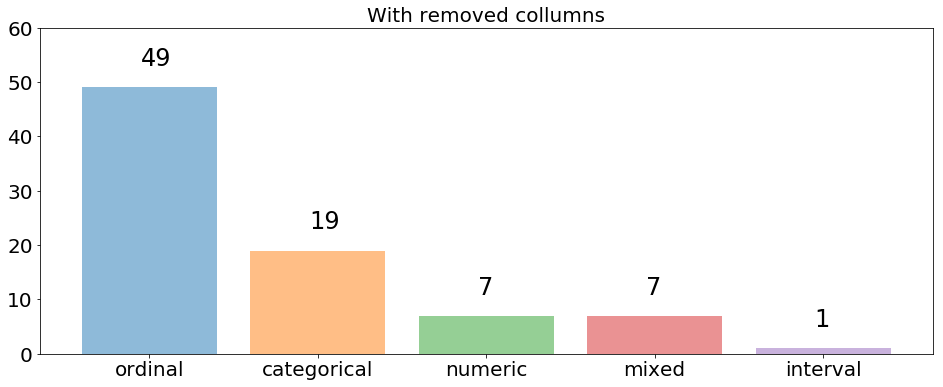

In [29]:
# How many features are there of each data type?

feat_info_mod = feat_info[feat_info['attribute'].isin(azdias_mod_2.columns.values)]

s = feat_info_mod['type'].value_counts()


# plt.figure(figsize=(16,6))
ax = s.plot.bar(width=.8, alpha=0.5, figsize=(16,6)) 
ax.set_ylim(0,60)

# draw counts
for i, v in s.reset_index().iterrows():
    ax.text(i-0.05, v.type + 4 , v.type, fontsize= 24)
    

plt.title("With removed collumns", fontsize= 20)
plt.xticks(rotation=0, fontsize= 20);
plt.yticks(fontsize= 20);

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [30]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

categorical_collumns = feat_info[feat_info.type == "categorical"].attribute.values
for _ in categorical_collumns:
    # make sure that feature is in azdias dataframe
    if _ in azdias_mod_2.columns:
        print("{:25s} | {}  ".format(_,azdias_mod_2[_].unique()))

ANREDE_KZ                 | [1 2]  
CJT_GESAMTTYP             | [ 2.  5.  3.  4.  1.  6. nan]  
FINANZTYP                 | [4 1 6 5 2 3]  
GFK_URLAUBERTYP           | [10.  1.  5. 12.  9.  3.  8. 11.  4.  2.  7.  6. nan]  
GREEN_AVANTGARDE          | [0 1]  
LP_FAMILIE_FEIN           | [ 2.  5.  1. nan 10.  7. 11.  3.  8.  4.  6.  9.]  
LP_FAMILIE_GROB           | [ 2.  3.  1. nan  5.  4.]  
LP_STATUS_FEIN            | [ 1.  2.  3.  9.  4. 10.  5.  8.  6.  7. nan]  
LP_STATUS_GROB            | [ 1.  2.  4.  5.  3. nan]  
NATIONALITAET_KZ          | [nan  1.  3.  2.]  
SHOPPER_TYP               | [nan  3.  2.  1.  0.]  
SOHO_KZ                   | [nan  1.  0.]  
VERS_TYP                  | [nan  2.  1.]  
ZABEOTYP                  | [3 5 4 1 6 2]  
KK_KUNDENTYP              | [nan  1.  3.  6.  4.  2.  5.]  
GEBAEUDETYP               | [nan  8.  1.  3.  2.  6.  4.  5.]  
OST_WEST_KZ               | [nan 'W' 'O']  
CAMEO_DEUG_2015           | [nan '8' '4' '2' '6' '1' '9' '5' '7' '3']  


### Feature english meanings:
* ANREDE_KZ                 (Gender)
* CJT_GESAMTTYP             (Customer-Journey-Typology: preferred information and buying channels for consumer)
* FINANZTYP            (Most descriptive financial type for individual)
* GFK_URLAUBERTYP           (Vacation habits)
* LP_FAMILIE_FEIN           (Family type, fine scale)
* LP_FAMILIE_GROB           (Family type, rough scale)
* LP_STATUS_FEIN            (Social status, fine scale)
* LP_STATUS_GROB            (Social status, rough scale)
* NATIONALITAET_KZ          (Nationality based on given name analysis)
* SHOPPER_TYP               (Shopper typology)
* SOHO_KZ                   (Small office / home office flag)
* VERS_TYP                  (Insurance typology)
* ZABEOTYP                  (Energy consumption typology)
* KK_KUNDENTYP              (Consumer pattern over past 12 months)
* GEBAEUDETYP               (Type of building (residential vs. commercial))
* OST_WEST_KZ               (Building location via former East / West Germany (GDR / FRG))
* CAMEO_DEUG_2015           (German CAMEO: Wealth / Life Stage Typology, rough scale)
* CAMEO_DEU_2015            (German CAMEO: Wealth / Life Stage Typology, detailed scale)

There are 3 dublicate features which only differ by scale, it's is either rough or detailed. I decided to check whatever there is same amount

In [31]:
print("LP_FAMILIE_FEIN has {:.2f} % missing data".format(azdias_mod_2.LP_FAMILIE_FEIN.isnull().sum() / azdias_mod_2.shape[0] * 100))
print("LP_FAMILIE_GROB has {:.2f} % missing data".format(azdias_mod_2.LP_FAMILIE_GROB.isnull().sum() / azdias_mod_2.shape[0] * 100))
print("LP_STATUS_FEIN has {:.2f} % missing data".format(azdias_mod_2.LP_STATUS_FEIN.isnull().sum() / azdias_mod_2.shape[0] * 100))
print("LP_STATUS_GROB has {:.2f} % missing data".format(azdias_mod_2.LP_STATUS_GROB.isnull().sum() / azdias_mod_2.shape[0] * 100))
print("CAMEO_DEUG_2015 has {:.2f} % missing data".format(azdias_mod_2.LP_FAMILIE_FEIN.isnull().sum() / azdias_mod_2.shape[0] * 100))
print("CAMEO_DEU_2015 has {:.2f} % missing data".format(azdias_mod_2.LP_FAMILIE_FEIN.isnull().sum() / azdias_mod_2.shape[0] * 100))

LP_FAMILIE_FEIN has 8.73 % missing data
LP_FAMILIE_GROB has 8.73 % missing data
LP_STATUS_FEIN has 0.54 % missing data
LP_STATUS_GROB has 0.54 % missing data
CAMEO_DEUG_2015 has 8.73 % missing data
CAMEO_DEU_2015 has 8.73 % missing data


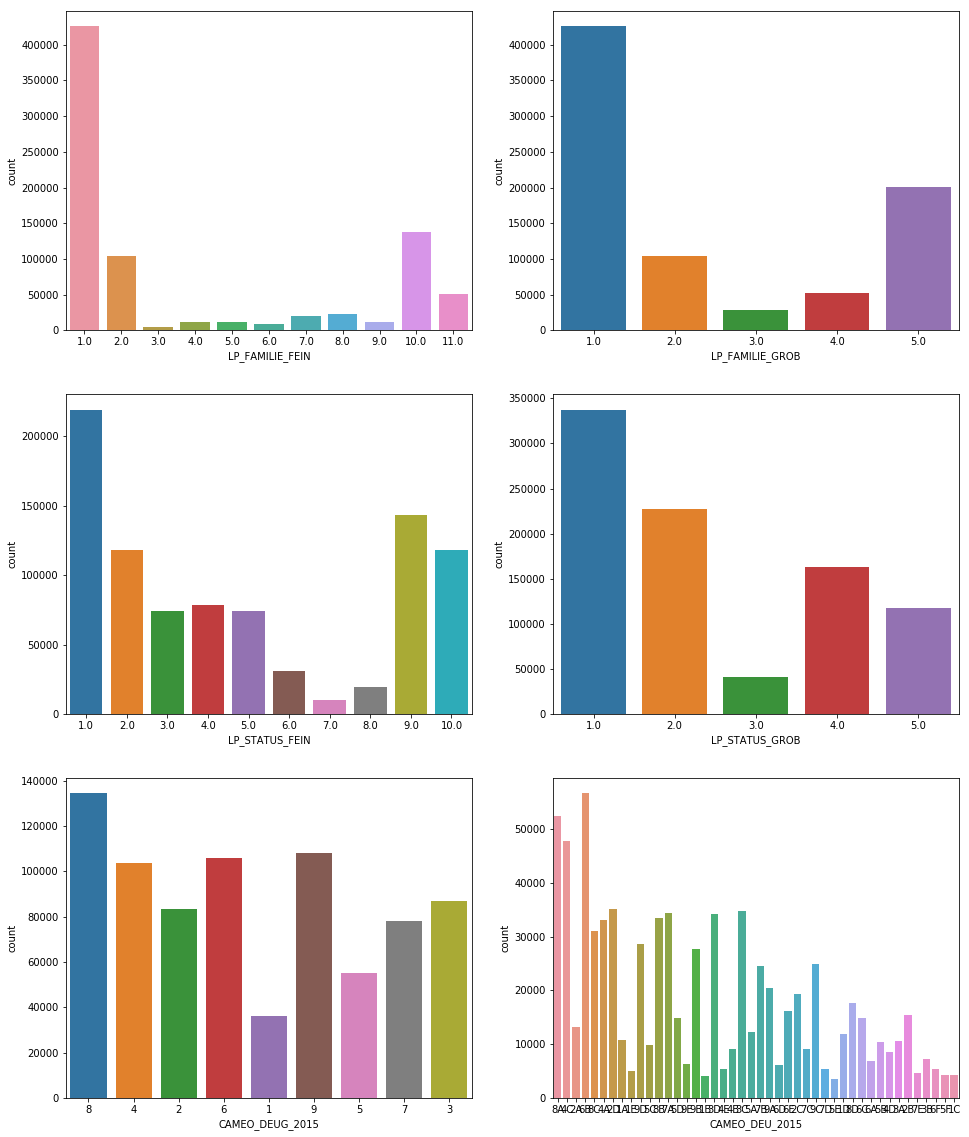

In [32]:
# Check distribution of these 
# sns.countplot(x="LP_FAMILIE_FEIN", data=azdias_mod_2);

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16,20))

collumn_names = ["LP_FAMILIE_FEIN", "LP_FAMILIE_GROB",
                "LP_STATUS_FEIN","LP_STATUS_GROB",
                "CAMEO_DEUG_2015","CAMEO_DEU_2015"]
for ax, name in zip(axes.flatten(),collumn_names):
    sns.countplot(x=name, data=azdias_mod_2, ax=ax)

###  Seems like rought features were derived from available data from detailed features
For first analysis I will stick with detailed features and remove rought features.

In [33]:
# remove rought features
azdias_mod_2 = azdias_mod_2.drop(["LP_FAMILIE_GROB", "LP_STATUS_GROB", "CAMEO_DEUG_2015"], axis=1)

In [34]:
# testing procedure
# for _ in categorical_collumns:
#     # make sure that feature is still in azdias dataframe
#     if _ in azdias_mod.columns[:-2]:
#         x = azdias_mod[_].unique()
#         if x.shape[0] > 2 and np.nan not in x:
#             # one-one-hot encode the feature and add it to the dataframe
#             azdias_mod = azdias_mod.join(pd.get_dummies(azdias_mod[_], prefix=_))
#             # drop feature from data
#             azdias_mod = azdias_mod.drop([_], axis=1)

In [25]:
def one_hot_encode(df, df_feat, drop_col = True):
    """
    One-hot-encodes categorical features
    """
    # get categorical feature names
    categorical_collumns = df_feat[feat_info.type == "categorical"].attribute.values
    # drop data_count_per_row and features
    if drop_col == True:
        df = df.drop(["data_count_per_row", "data_split"], axis=1)       
    
    for _ in categorical_collumns:
        # checks if feature is still present in dataframe
        if _ in df.columns:
            # checks unique values
            x = df[_].unique()
            # exclused binary features
            if x.shape[0] > 2 and np.nan not in x:                
                # one-one-hot encode the feature and add it to the dataframe
                df = df.join(pd.get_dummies(df[_], prefix=_))
                # drop feature from data
                df = df.drop([_], axis=1)
                print("{:20s} feature one-hot-encoded".format(_))
                
    return df

In [36]:
# Re-encode categorical variable(s) to be kept in the analysis.

azdias_mod_3 = one_hot_encode(azdias_mod_2, feat_info)

CJT_GESAMTTYP        feature one-hot-encoded
FINANZTYP            feature one-hot-encoded
GFK_URLAUBERTYP      feature one-hot-encoded
LP_FAMILIE_FEIN      feature one-hot-encoded
LP_STATUS_FEIN       feature one-hot-encoded
NATIONALITAET_KZ     feature one-hot-encoded
SHOPPER_TYP          feature one-hot-encoded
SOHO_KZ              feature one-hot-encoded
VERS_TYP             feature one-hot-encoded
ZABEOTYP             feature one-hot-encoded
KK_KUNDENTYP         feature one-hot-encoded
GEBAEUDETYP          feature one-hot-encoded
OST_WEST_KZ          feature one-hot-encoded
CAMEO_DEU_2015       feature one-hot-encoded


In [37]:
# check that all collumns were successfully one-hot-encoded
for _ in azdias_mod_3.columns:
    print(_)

ALTERSKATEGORIE_GROB
ANREDE_KZ
FINANZ_MINIMALIST
FINANZ_SPARER
FINANZ_VORSORGER
FINANZ_ANLEGER
FINANZ_UNAUFFAELLIGER
FINANZ_HAUSBAUER
GEBURTSJAHR
GREEN_AVANTGARDE
HEALTH_TYP
LP_LEBENSPHASE_FEIN
LP_LEBENSPHASE_GROB
PRAEGENDE_JUGENDJAHRE
RETOURTYP_BK_S
SEMIO_SOZ
SEMIO_FAM
SEMIO_REL
SEMIO_MAT
SEMIO_VERT
SEMIO_LUST
SEMIO_ERL
SEMIO_KULT
SEMIO_RAT
SEMIO_KRIT
SEMIO_DOM
SEMIO_KAEM
SEMIO_PFLICHT
SEMIO_TRADV
ALTER_HH
ANZ_PERSONEN
ANZ_TITEL
HH_EINKOMMEN_SCORE
W_KEIT_KIND_HH
WOHNDAUER_2008
ANZ_HAUSHALTE_AKTIV
ANZ_HH_TITEL
KONSUMNAEHE
MIN_GEBAEUDEJAHR
WOHNLAGE
CAMEO_INTL_2015
KBA05_ANTG1
KBA05_ANTG2
KBA05_ANTG3
KBA05_ANTG4
KBA05_BAUMAX
KBA05_GBZ
BALLRAUM
EWDICHTE
INNENSTADT
GEBAEUDETYP_RASTER
KKK
MOBI_REGIO
ONLINE_AFFINITAET
REGIOTYP
KBA13_ANZAHL_PKW
PLZ8_ANTG1
PLZ8_ANTG2
PLZ8_ANTG3
PLZ8_ANTG4
PLZ8_BAUMAX
PLZ8_HHZ
PLZ8_GBZ
ARBEIT
ORTSGR_KLS9
RELAT_AB
CJT_GESAMTTYP_1.0
CJT_GESAMTTYP_2.0
CJT_GESAMTTYP_3.0
CJT_GESAMTTYP_4.0
CJT_GESAMTTYP_5.0
CJT_GESAMTTYP_6.0
FINANZTYP_1
FINANZTYP_2
FINANZTYP_3
FINANZ

#### Discussion 1.2.1: Re-Encode Categorical Features

Out of 83 remaining features 19 were catergorical (49 ordinal, 7 numeric, 7 mixed and one interval). 
After translating categorical features in english, I found that 3 features had dublicates, information was available in rough or detailed "scales". After closer anlysis, I decided to drop rough features and analyze data only with detailed features.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [38]:
azdias_mod_4 = azdias_mod_3.copy()

In [39]:
# replace NaN value with 0 so it can be used as dictonary key and visualized with seaborn
azdias_mod_4.PRAEGENDE_JUGENDJAHRE = azdias_mod_4.PRAEGENDE_JUGENDJAHRE.replace(np.nan, 0.0);

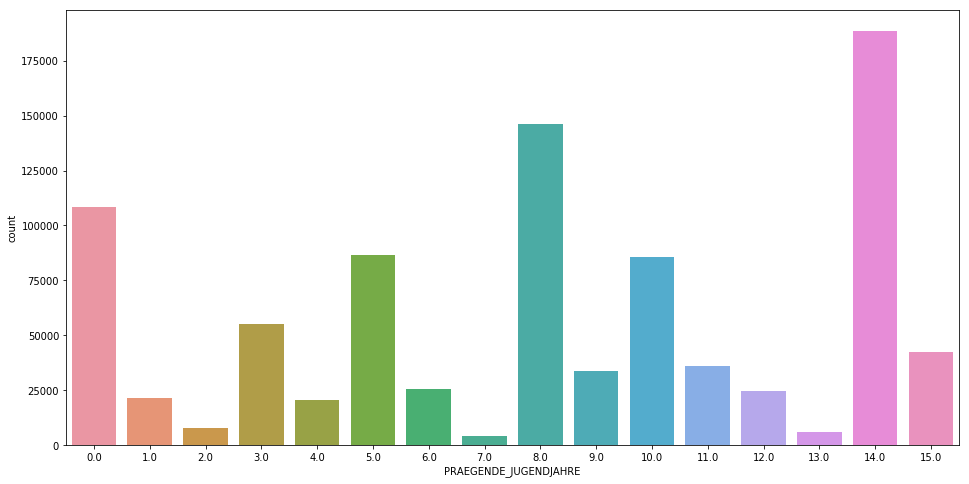

In [40]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# visual analysis
plt.figure(figsize=(16,8))
sns.countplot(x="PRAEGENDE_JUGENDJAHRE", data=azdias_mod_4);

Seems like all values have some data.
"Mainstream" and "Avantgarde" were encoded as bianry categorical data {"Mainstream": 0, "Avantgarde": 1}

In [41]:
# I will use dictonary to encode diffent values to different collumn
PRAEGENDE_JUGENDJAHRE_dict = {
    0.0: [np.nan, np.nan],
    1.0: ["40s", 0],
    2.0: ["40s", 1],
    3.0: ["50s", 0],
    4.0: ["50s", 1],
    5.0: ["60s", 0],
    6.0: ["60s", 1],
    7.0: ["60s", 1],
    8.0: ["70s", 0],
    9.0: ["70s", 1],
    10.0: ["80s", 0],
    11.0: ["80s", 1],
    12.0: ["80s", 0],
    13.0: ["80s", 1],
    14.0: ["90s", 0],
    15.0: ["90s", 1]
}

In [42]:
%%time

# create new collumns for decade and movement values
other = azdias_mod_4.PRAEGENDE_JUGENDJAHRE.apply(lambda s: pd.Series({
    'PRAEGENDE_JUGENDJAHRE_decade':PRAEGENDE_JUGENDJAHRE_dict[s][0],
    'PRAEGENDE_JUGENDJAHRE_movement':PRAEGENDE_JUGENDJAHRE_dict[s][1]}))
# add these collumns to data frame
azdias_mod_4 = azdias_mod_4.merge(other, left_index=True, right_index=True);
# drop PRAEGENDE_JUGENDJAHRE collumn from dataframe
azdias_mod_4 = azdias_mod_4.drop(["PRAEGENDE_JUGENDJAHRE"], axis=1);
# one-hot-encode decade data
azdias_mod_4 = azdias_mod_4.join(pd.get_dummies(azdias_mod_4["PRAEGENDE_JUGENDJAHRE_decade"],
                                                prefix="PRAEGENDE_JUGENDJAHRE_decade"))
azdias_mod_4 = azdias_mod_4.drop(["PRAEGENDE_JUGENDJAHRE_decade"], axis=1);

Wall time: 7min 44s


In [43]:
# check that all collumns were successfully one-hot-encoded
for _ in azdias_mod_4.columns:
    print(_)

ALTERSKATEGORIE_GROB
ANREDE_KZ
FINANZ_MINIMALIST
FINANZ_SPARER
FINANZ_VORSORGER
FINANZ_ANLEGER
FINANZ_UNAUFFAELLIGER
FINANZ_HAUSBAUER
GEBURTSJAHR
GREEN_AVANTGARDE
HEALTH_TYP
LP_LEBENSPHASE_FEIN
LP_LEBENSPHASE_GROB
RETOURTYP_BK_S
SEMIO_SOZ
SEMIO_FAM
SEMIO_REL
SEMIO_MAT
SEMIO_VERT
SEMIO_LUST
SEMIO_ERL
SEMIO_KULT
SEMIO_RAT
SEMIO_KRIT
SEMIO_DOM
SEMIO_KAEM
SEMIO_PFLICHT
SEMIO_TRADV
ALTER_HH
ANZ_PERSONEN
ANZ_TITEL
HH_EINKOMMEN_SCORE
W_KEIT_KIND_HH
WOHNDAUER_2008
ANZ_HAUSHALTE_AKTIV
ANZ_HH_TITEL
KONSUMNAEHE
MIN_GEBAEUDEJAHR
WOHNLAGE
CAMEO_INTL_2015
KBA05_ANTG1
KBA05_ANTG2
KBA05_ANTG3
KBA05_ANTG4
KBA05_BAUMAX
KBA05_GBZ
BALLRAUM
EWDICHTE
INNENSTADT
GEBAEUDETYP_RASTER
KKK
MOBI_REGIO
ONLINE_AFFINITAET
REGIOTYP
KBA13_ANZAHL_PKW
PLZ8_ANTG1
PLZ8_ANTG2
PLZ8_ANTG3
PLZ8_ANTG4
PLZ8_BAUMAX
PLZ8_HHZ
PLZ8_GBZ
ARBEIT
ORTSGR_KLS9
RELAT_AB
CJT_GESAMTTYP_1.0
CJT_GESAMTTYP_2.0
CJT_GESAMTTYP_3.0
CJT_GESAMTTYP_4.0
CJT_GESAMTTYP_5.0
CJT_GESAMTTYP_6.0
FINANZTYP_1
FINANZTYP_2
FINANZTYP_3
FINANZTYP_4
FINANZTYP_5
FINA

### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [44]:
%%time
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# convert to float values for numerical encoding
azdias_mod_4.CAMEO_INTL_2015 = azdias_mod_4.CAMEO_INTL_2015.astype('float')

# create new collumns for decade and movement values
other = azdias_mod_4.CAMEO_INTL_2015.apply(lambda s: pd.Series({
    'CAMEO_INTL_2015_wealth':s//10,
    'CAMEO_INTL_2015_lifestage':s%10}))
# add these collumns to data frame
azdias_mod_4 = azdias_mod_4.merge(other, left_index=True, right_index=True);
# drop CAMEO_INTL_2015 collumn from dataframe
azdias_mod_4 = azdias_mod_4.drop(["CAMEO_INTL_2015"], axis=1);
# one-hot-encode wealth and lifestage data
azdias_mod_4 = azdias_mod_4.join(pd.get_dummies(azdias_mod_4["CAMEO_INTL_2015_wealth"],
                                                prefix="CAMEO_INTL_2015_wealth"))
azdias_mod_4 = azdias_mod_4.join(pd.get_dummies(azdias_mod_4["CAMEO_INTL_2015_lifestage"],
                                                prefix="CAMEO_INTL_2015_lifestage"))
# drop one-hot-encoded original collumns
azdias_mod_4 = azdias_mod_4.drop(["CAMEO_INTL_2015_wealth"], axis=1);
azdias_mod_4 = azdias_mod_4.drop(["CAMEO_INTL_2015_lifestage"], axis=1);

Wall time: 7min 36s


In [45]:
# check that all collumns were successfully one-hot-encoded
for _ in azdias_mod_4.columns:
    print(_)

ALTERSKATEGORIE_GROB
ANREDE_KZ
FINANZ_MINIMALIST
FINANZ_SPARER
FINANZ_VORSORGER
FINANZ_ANLEGER
FINANZ_UNAUFFAELLIGER
FINANZ_HAUSBAUER
GEBURTSJAHR
GREEN_AVANTGARDE
HEALTH_TYP
LP_LEBENSPHASE_FEIN
LP_LEBENSPHASE_GROB
RETOURTYP_BK_S
SEMIO_SOZ
SEMIO_FAM
SEMIO_REL
SEMIO_MAT
SEMIO_VERT
SEMIO_LUST
SEMIO_ERL
SEMIO_KULT
SEMIO_RAT
SEMIO_KRIT
SEMIO_DOM
SEMIO_KAEM
SEMIO_PFLICHT
SEMIO_TRADV
ALTER_HH
ANZ_PERSONEN
ANZ_TITEL
HH_EINKOMMEN_SCORE
W_KEIT_KIND_HH
WOHNDAUER_2008
ANZ_HAUSHALTE_AKTIV
ANZ_HH_TITEL
KONSUMNAEHE
MIN_GEBAEUDEJAHR
WOHNLAGE
KBA05_ANTG1
KBA05_ANTG2
KBA05_ANTG3
KBA05_ANTG4
KBA05_BAUMAX
KBA05_GBZ
BALLRAUM
EWDICHTE
INNENSTADT
GEBAEUDETYP_RASTER
KKK
MOBI_REGIO
ONLINE_AFFINITAET
REGIOTYP
KBA13_ANZAHL_PKW
PLZ8_ANTG1
PLZ8_ANTG2
PLZ8_ANTG3
PLZ8_ANTG4
PLZ8_BAUMAX
PLZ8_HHZ
PLZ8_GBZ
ARBEIT
ORTSGR_KLS9
RELAT_AB
CJT_GESAMTTYP_1.0
CJT_GESAMTTYP_2.0
CJT_GESAMTTYP_3.0
CJT_GESAMTTYP_4.0
CJT_GESAMTTYP_5.0
CJT_GESAMTTYP_6.0
FINANZTYP_1
FINANZTYP_2
FINANZTYP_3
FINANZTYP_4
FINANZTYP_5
FINANZTYP_6
GFK_URLA

## Engineering other mixed features

In [46]:
# print names of mixed collumns
mixed_collumns = feat_info[feat_info.type == "mixed"].attribute.values
for _ in mixed_collumns:
    print("{}".format(_))

LP_LEBENSPHASE_FEIN
LP_LEBENSPHASE_GROB
PRAEGENDE_JUGENDJAHRE
WOHNLAGE
CAMEO_INTL_2015
KBA05_BAUMAX
PLZ8_BAUMAX


### 1.11. LP_LEBENSPHASE_FEIN
Life stage, fine scale
-  1: single low-income earners of younger age
-  2: single low-income earners of middle age
-  3: single average earners of younger age
-  4: single average earners of middle age
-  5: single low-income earners of advanced age
-  6: single low-income earners at retirement age
-  7: single average earners of advanced age
-  8: single average earners at retirement age
-  9: single independent persons
- 10: wealthy single homeowners
- 11: single homeowners of advanced age
- 12: single homeowners at retirement age
- 13: single top earners of higher age
- 14: low-income and average earner couples of younger age
- 15: low-income earner couples of higher age
- 16: average earner couples of higher age
- 17: independent couples
- 18: wealthy homeowner couples of younger age
- 19: homeowner couples of higher age
- 20: top earner couples of higher age
- 21: single parent low-income earners
- 22: single parent average earners
- 23: single parent high-income earners
- 24: low-income earner families
- 25: average earner families
- 26: independent families
- 27: homeowner families
- 28: top earner families
- 29: low-income earners of younger age from multiperson households
- 30: average earners of younger age from multiperson households
- 31: low-income earners of higher age from multiperson households
- 32: average earners of higher age from multiperson households
- 33: independent persons of younger age from multiperson households
- 34: homeowners of younger age from multiperson households
- 35: top earners of younger age from multiperson households
- 36: independent persons of higher age from multiperson households
- 37: homeowners of advanced age from multiperson households
- 38: homeowners at retirement age from multiperson households
- 39: top earners of middle age from multiperson households
- 40: top earners at retirement age from multiperson households

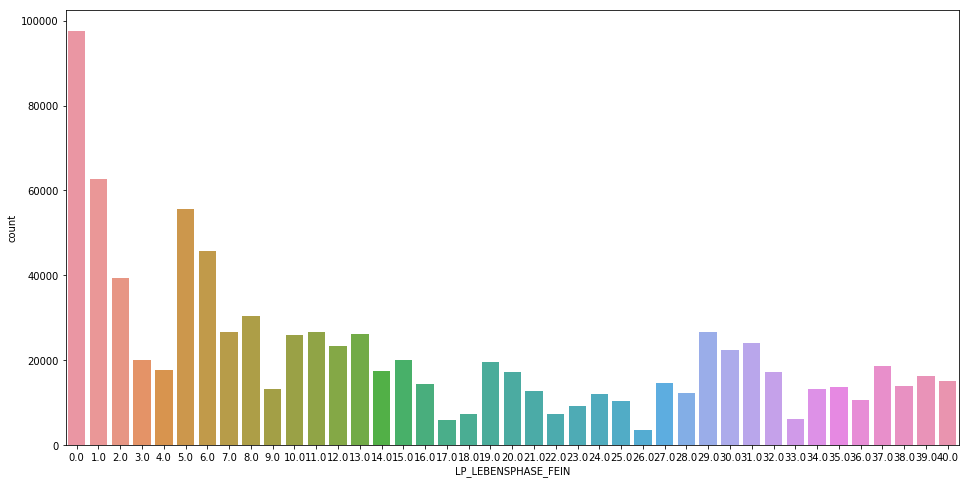

In [47]:
# visualize how much data is missing 
test = azdias_mod_4.copy()
test.LP_LEBENSPHASE_FEIN = test.LP_LEBENSPHASE_FEIN.replace(np.nan, 0.0);
plt.figure(figsize=(16,8))
sns.countplot(x="LP_LEBENSPHASE_FEIN", data=test);

`LP_LEBENSPHASE_FEIN` feature has information about age stage, income status and whatever household is single or multi person household. I decided to create a dictonary to map these features.

In [48]:
LP_LEBENSPHASE_FEIN_dict = {
    0.0: [np.nan, np.nan, np.nan],
    1.0: ["single", "low", "young"],
    2.0: ["single", "low", "middle"],
    3.0: ["single", "average", "young"],
    4.0: ["single", "average", "middle"],
    5.0: ["single", "low", "advanced"],
    6.0: ["single", "low", "retirement"],
    7.0: ["single", "average", "advanced"],
    8.0: ["single", "average", "retirement"],
    9.0: ['single', np.nan, np.nan],
    10.0: ['single_home', 'high', np.nan],
    11.0: ['single_home', np.nan, "advanced"],
    12.0: ['single_home', np.nan, "retirement"],
    13.0: ['single', 'high', "higher"],
    14.0: ["couple", 'average', 'young'],
    15.0: ["couple", "low", 'higher'],
    16.0: ['couple', "average", "higher"],
    17.0: ['couple', np.nan, np.nan],
    18.0: ['couple', 'high', 'young'],
    19.0: ['couple', np.nan, "higher"],
    20.0: ['couple', 'high', "higher"],
    21.0: ['single_parent', 'low', np.nan],
    22.0: ['single_parent', 'average', np.nan],
    23.0: ['single_parent', 'high', np.nan],
    24.0: ['family', 'low', np.nan],
    25.0: ['family', 'average', np.nan],
    26.0: ['family', np.nan, np.nan],
    27.0: ['family', np.nan, np.nan],
    28.0: ['family', 'high', np.nan],
    29.0: ['multi', 'low', 'young'],
    30.0: ['multi', 'average', 'young'],
    31.0: ['multi', 'low', 'higher'],
    32.0: ['multi', 'average', 'higher'],
    33.0: ['multi', np.nan , 'young'],
    34.0: ['multi', np.nan , 'young'],
    35.0: ['multi', 'high' , 'young'],
    36.0: ['multi', np.nan , 'higher'],
    37.0: ['multi', np.nan , 'advanced'],
    38.0: ['multi', np.nan , 'retirement'],
    39.0: ['multi', 'high' , 'middle'],
    40.0: ['multi', 'high' , 'retirement']    
}

## comments regarding interpretation of some of the features when generating dictonary
* single independent person was encoded as single with unknown income and age.
* wealthy was interpreted as high income.
* independent couple were recorded as couple with unknown income and age.
* homeowner couples of higher age were recorded as couples with unknown income.
* top earner couples of higher age were recorder as couples with high income and higher age
* independent families, homeowner families were recorded as just families with unknow income and age
* independent persons of younger age from multiperson households and homeowners of younger age from multiperson households were recorded as multiperson household with unknown income and youg age.
* top earners of younger age from multiperson households were recorded as multiperson household with high income
* top earners of middle age from multiperson households were recorded as multiperson household with high income and midle age

In [49]:
%%time
# change NAN values so that you can access dictonary
azdias_mod_4.LP_LEBENSPHASE_FEIN = azdias_mod_4.LP_LEBENSPHASE_FEIN.replace(np.nan, 0.0);
# create new collumns for decade and movement values
other = azdias_mod_4.LP_LEBENSPHASE_FEIN.apply(lambda s: pd.Series({
    'LP_LEBENSPHASE_FEIN_type':LP_LEBENSPHASE_FEIN_dict[s][0],
    'LP_LEBENSPHASE_FEIN_income':LP_LEBENSPHASE_FEIN_dict[s][1],
    'LP_LEBENSPHASE_FEIN_age':LP_LEBENSPHASE_FEIN_dict[s][2]}))
# add these collumns to data frame
azdias_mod_4 = azdias_mod_4.merge(other, left_index=True, right_index=True);
# drop LP_LEBENSPHASE_FEIN collumn from dataframe
azdias_mod_4 = azdias_mod_4.drop(["LP_LEBENSPHASE_FEIN"], axis=1);

Wall time: 7min 59s


In [50]:
# check unique values (if I haven't made a typp)
print("LP_LEBENSPHASE_FEIN_type: {}".format(azdias_mod_4.LP_LEBENSPHASE_FEIN_type.unique()))
print("LP_LEBENSPHASE_FEIN_income: {}".format(azdias_mod_4.LP_LEBENSPHASE_FEIN_income.unique()))
print("LP_LEBENSPHASE_FEIN_age: {}".format(azdias_mod_4.LP_LEBENSPHASE_FEIN_age.unique()))

LP_LEBENSPHASE_FEIN_type: ['couple' 'single_parent' 'single' nan 'multi' 'single_home' 'family']
LP_LEBENSPHASE_FEIN_income: ['low' 'average' nan 'high']
LP_LEBENSPHASE_FEIN_age: ['higher' nan 'young' 'retirement' 'middle' 'advanced']


In [51]:
# one-hot-encode type, income and age
azdias_mod_4 = azdias_mod_4.join(pd.get_dummies(azdias_mod_4["LP_LEBENSPHASE_FEIN_type"],
                                                prefix="LP_LEBENSPHASE_FEIN_type"))
azdias_mod_4 = azdias_mod_4.drop(["LP_LEBENSPHASE_FEIN_type"], axis=1);

azdias_mod_4 = azdias_mod_4.join(pd.get_dummies(azdias_mod_4["LP_LEBENSPHASE_FEIN_income"],
                                                prefix="LP_LEBENSPHASE_FEIN_income"))
azdias_mod_4 = azdias_mod_4.drop(["LP_LEBENSPHASE_FEIN_income"], axis=1);

azdias_mod_4 = azdias_mod_4.join(pd.get_dummies(azdias_mod_4["LP_LEBENSPHASE_FEIN_age"],
                                                prefix="LP_LEBENSPHASE_FEIN_age"))
azdias_mod_4 = azdias_mod_4.drop(["LP_LEBENSPHASE_FEIN_age"], axis=1);

In [52]:
# check that all collumns were successfully one-hot-encoded
for _ in azdias_mod_4.columns:
    print(_)

ALTERSKATEGORIE_GROB
ANREDE_KZ
FINANZ_MINIMALIST
FINANZ_SPARER
FINANZ_VORSORGER
FINANZ_ANLEGER
FINANZ_UNAUFFAELLIGER
FINANZ_HAUSBAUER
GEBURTSJAHR
GREEN_AVANTGARDE
HEALTH_TYP
LP_LEBENSPHASE_GROB
RETOURTYP_BK_S
SEMIO_SOZ
SEMIO_FAM
SEMIO_REL
SEMIO_MAT
SEMIO_VERT
SEMIO_LUST
SEMIO_ERL
SEMIO_KULT
SEMIO_RAT
SEMIO_KRIT
SEMIO_DOM
SEMIO_KAEM
SEMIO_PFLICHT
SEMIO_TRADV
ALTER_HH
ANZ_PERSONEN
ANZ_TITEL
HH_EINKOMMEN_SCORE
W_KEIT_KIND_HH
WOHNDAUER_2008
ANZ_HAUSHALTE_AKTIV
ANZ_HH_TITEL
KONSUMNAEHE
MIN_GEBAEUDEJAHR
WOHNLAGE
KBA05_ANTG1
KBA05_ANTG2
KBA05_ANTG3
KBA05_ANTG4
KBA05_BAUMAX
KBA05_GBZ
BALLRAUM
EWDICHTE
INNENSTADT
GEBAEUDETYP_RASTER
KKK
MOBI_REGIO
ONLINE_AFFINITAET
REGIOTYP
KBA13_ANZAHL_PKW
PLZ8_ANTG1
PLZ8_ANTG2
PLZ8_ANTG3
PLZ8_ANTG4
PLZ8_BAUMAX
PLZ8_HHZ
PLZ8_GBZ
ARBEIT
ORTSGR_KLS9
RELAT_AB
CJT_GESAMTTYP_1.0
CJT_GESAMTTYP_2.0
CJT_GESAMTTYP_3.0
CJT_GESAMTTYP_4.0
CJT_GESAMTTYP_5.0
CJT_GESAMTTYP_6.0
FINANZTYP_1
FINANZTYP_2
FINANZTYP_3
FINANZTYP_4
FINANZTYP_5
FINANZTYP_6
GFK_URLAUBERTYP_1.0
GFK_URLA

### 1.12. LP_LEBENSPHASE_GROB
Life stage, rough scale
-  1: single low-income and average earners of younger age
-  2: single low-income and average earners of higher age
-  3: single high-income earners
-  4: single low-income and average-earner couples
-  5: single high-income earner couples
-  6: single parents
-  7: single low-income and average earner families
-  8: high-income earner families
-  9: average earners of younger age from multiperson households
- 10: low-income and average earners of higher age from multiperson households
- 11: high-income earners of younger age from multiperson households
- 12: high-income earners of higher age from multiperson households

`LP_LEBENSPHASE_GROB` is has same data as `LP_LEBENSPHASE_FEIN` I will simply drop it

In [53]:
azdias_mod_4 = azdias_mod_4.drop(["LP_LEBENSPHASE_GROB"], axis=1);

### 3.7. WOHNLAGE
Neighborhood quality (or rural flag)
- -1: unknown
-  0: no score calculated
-  1: very good neighborhood
-  2: good neighborhood
-  3: average neighborhood
-  4: poor neighborhood
-  5: very poor neighborhood
-  7: rural neighborhood
-  8: new building in rural neighborhood

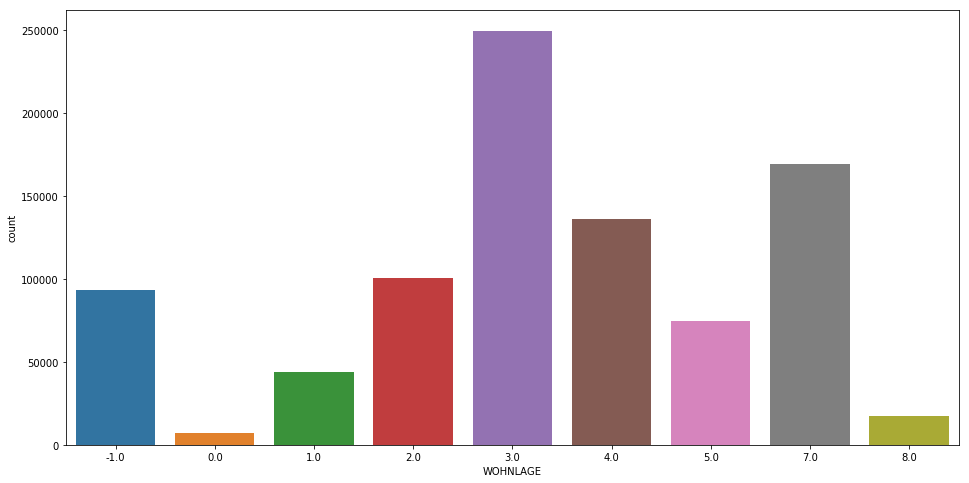

In [54]:
# visualize how much data is missing 
test = azdias_mod_4.copy()
test.WOHNLAGE = test.WOHNLAGE.replace(np.nan, -1.0);
plt.figure(figsize=(16,8))
sns.countplot(x="WOHNLAGE", data=test);

In [55]:
# how many rows have rular flag
test.WOHNLAGE[(test.WOHNLAGE == 7.0) | (test.WOHNLAGE == 8.0)].count() / test.shape[0] * 100

20.95899894638928

In [56]:
WOHNLAGE_dict = {
    -1.0: [np.nan, np.nan],
    0.0: [np.nan, np.nan],
    1.0: ["very good", 0],
    2.0: ["good", 0],
    3.0: ["average", 0],
    4.0: ["poor", 0],
    5.0: ["very poor", 0],
    7.0: [np.nan, 1],
    8.0: ["new building", 1]
}

In [57]:
%%time
# change NAN values so that you can access dictonary
azdias_mod_4.WOHNLAGE = azdias_mod_4.WOHNLAGE.replace(np.nan, -1.0);
# create new collumns for decade and movement values
other = azdias_mod_4.WOHNLAGE.apply(lambda s: pd.Series({
    'WOHNLAGE_score':WOHNLAGE_dict[s][0],
    'WOHNLAGE_score_rular':WOHNLAGE_dict[s][1]}))
# add these collumns to data frame
azdias_mod_4 = azdias_mod_4.merge(other, left_index=True, right_index=True);
# drop WOHNLAGE collumn from dataframe
azdias_mod_4 = azdias_mod_4.drop(["WOHNLAGE"], axis=1);

Wall time: 7min 53s


In [58]:
# one-hot-encode WOHNLAGE score
azdias_mod_4 = azdias_mod_4.join(pd.get_dummies(azdias_mod_4["WOHNLAGE_score"],
                                                prefix="WOHNLAGE_score"))
azdias_mod_4 = azdias_mod_4.drop(["WOHNLAGE_score"], axis=1);

In [59]:
# check that all collumns were successfully one-hot-encoded
for _ in azdias_mod_4.columns:
    print(_)

ALTERSKATEGORIE_GROB
ANREDE_KZ
FINANZ_MINIMALIST
FINANZ_SPARER
FINANZ_VORSORGER
FINANZ_ANLEGER
FINANZ_UNAUFFAELLIGER
FINANZ_HAUSBAUER
GEBURTSJAHR
GREEN_AVANTGARDE
HEALTH_TYP
RETOURTYP_BK_S
SEMIO_SOZ
SEMIO_FAM
SEMIO_REL
SEMIO_MAT
SEMIO_VERT
SEMIO_LUST
SEMIO_ERL
SEMIO_KULT
SEMIO_RAT
SEMIO_KRIT
SEMIO_DOM
SEMIO_KAEM
SEMIO_PFLICHT
SEMIO_TRADV
ALTER_HH
ANZ_PERSONEN
ANZ_TITEL
HH_EINKOMMEN_SCORE
W_KEIT_KIND_HH
WOHNDAUER_2008
ANZ_HAUSHALTE_AKTIV
ANZ_HH_TITEL
KONSUMNAEHE
MIN_GEBAEUDEJAHR
KBA05_ANTG1
KBA05_ANTG2
KBA05_ANTG3
KBA05_ANTG4
KBA05_BAUMAX
KBA05_GBZ
BALLRAUM
EWDICHTE
INNENSTADT
GEBAEUDETYP_RASTER
KKK
MOBI_REGIO
ONLINE_AFFINITAET
REGIOTYP
KBA13_ANZAHL_PKW
PLZ8_ANTG1
PLZ8_ANTG2
PLZ8_ANTG3
PLZ8_ANTG4
PLZ8_BAUMAX
PLZ8_HHZ
PLZ8_GBZ
ARBEIT
ORTSGR_KLS9
RELAT_AB
CJT_GESAMTTYP_1.0
CJT_GESAMTTYP_2.0
CJT_GESAMTTYP_3.0
CJT_GESAMTTYP_4.0
CJT_GESAMTTYP_5.0
CJT_GESAMTTYP_6.0
FINANZTYP_1
FINANZTYP_2
FINANZTYP_3
FINANZTYP_4
FINANZTYP_5
FINANZTYP_6
GFK_URLAUBERTYP_1.0
GFK_URLAUBERTYP_2.0
GFK_URLAUBERTYP_3

### 5.5. KBA05_BAUMAX
Most common building type within the microcell
- -1: unknown
-  0: unknown
-  1: mainly 1-2 family homes in the microcell
-  2: mainly 3-5 family homes in the microcell
-  3: mainly 6-10 family homes in the microcell
-  4: mainly 10+ family homes in the microcell
-  5: mainly business buildings in the microcell

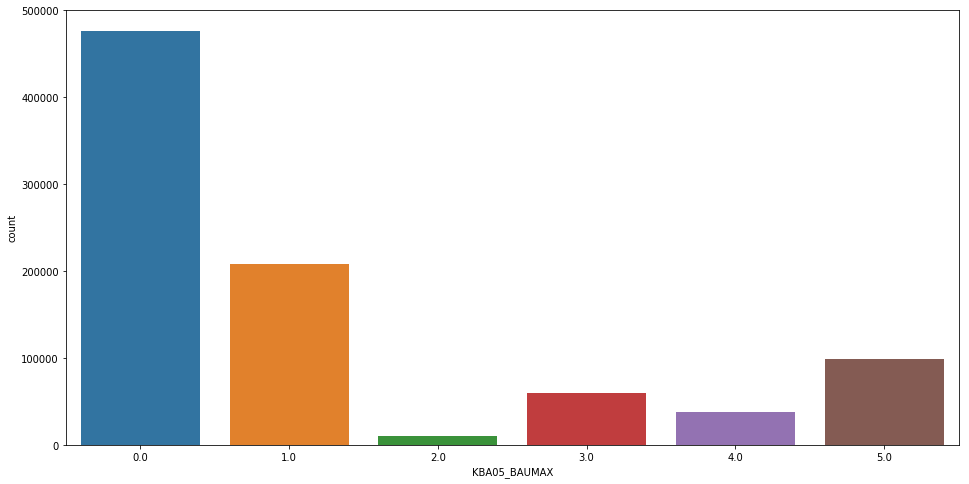

In [60]:
# visualize how much data is missing 
test = azdias_mod_4.copy()
test.KBA05_BAUMAX = test.KBA05_BAUMAX.replace(np.nan, 0.0);
plt.figure(figsize=(16,8))
sns.countplot(x="KBA05_BAUMAX", data=test);

In [61]:
# how many rows have busines building
test.KBA05_BAUMAX[(test.KBA05_BAUMAX == 5.0)].count() / test.shape[0] * 100

11.099716007589588

In [62]:
KBA05_BAUMAX_dict = {
    0.0: [np.nan, np.nan],
    1.0: ["1-2", 0],
    2.0: ["3-5", 0],
    3.0: ["6-10", 0],
    4.0: ["10+", 0],
    5.0: [np.nan, 1]
}

In [63]:
%%time
# change NAN values so that you can access dictonary
azdias_mod_4.KBA05_BAUMAX = azdias_mod_4.KBA05_BAUMAX.replace(np.nan, 0.0);
# create new collumns for decade and movement values
other = azdias_mod_4.KBA05_BAUMAX.apply(lambda s: pd.Series({
    'KBA05_BAUMAX_size':KBA05_BAUMAX_dict[s][0],
    'KBA05_BAUMAX_cell_type':KBA05_BAUMAX_dict[s][1]}))
# add these collumns to data frame
azdias_mod_4 = azdias_mod_4.merge(other, left_index=True, right_index=True);
# drop WOHNLAGE collumn from dataframe
azdias_mod_4 = azdias_mod_4.drop(["KBA05_BAUMAX"], axis=1);

Wall time: 7min 46s


In [64]:
# one-hot-encode WOHNLAGE score
azdias_mod_4 = azdias_mod_4.join(pd.get_dummies(azdias_mod_4["KBA05_BAUMAX_size"],
                                                prefix="KBA05_BAUMAX_size"))
azdias_mod_4 = azdias_mod_4.drop(["KBA05_BAUMAX_size"], axis=1);

In [65]:
# check that all collumns were successfully one-hot-encoded
for _ in azdias_mod_4.columns:
    print(_)

ALTERSKATEGORIE_GROB
ANREDE_KZ
FINANZ_MINIMALIST
FINANZ_SPARER
FINANZ_VORSORGER
FINANZ_ANLEGER
FINANZ_UNAUFFAELLIGER
FINANZ_HAUSBAUER
GEBURTSJAHR
GREEN_AVANTGARDE
HEALTH_TYP
RETOURTYP_BK_S
SEMIO_SOZ
SEMIO_FAM
SEMIO_REL
SEMIO_MAT
SEMIO_VERT
SEMIO_LUST
SEMIO_ERL
SEMIO_KULT
SEMIO_RAT
SEMIO_KRIT
SEMIO_DOM
SEMIO_KAEM
SEMIO_PFLICHT
SEMIO_TRADV
ALTER_HH
ANZ_PERSONEN
ANZ_TITEL
HH_EINKOMMEN_SCORE
W_KEIT_KIND_HH
WOHNDAUER_2008
ANZ_HAUSHALTE_AKTIV
ANZ_HH_TITEL
KONSUMNAEHE
MIN_GEBAEUDEJAHR
KBA05_ANTG1
KBA05_ANTG2
KBA05_ANTG3
KBA05_ANTG4
KBA05_GBZ
BALLRAUM
EWDICHTE
INNENSTADT
GEBAEUDETYP_RASTER
KKK
MOBI_REGIO
ONLINE_AFFINITAET
REGIOTYP
KBA13_ANZAHL_PKW
PLZ8_ANTG1
PLZ8_ANTG2
PLZ8_ANTG3
PLZ8_ANTG4
PLZ8_BAUMAX
PLZ8_HHZ
PLZ8_GBZ
ARBEIT
ORTSGR_KLS9
RELAT_AB
CJT_GESAMTTYP_1.0
CJT_GESAMTTYP_2.0
CJT_GESAMTTYP_3.0
CJT_GESAMTTYP_4.0
CJT_GESAMTTYP_5.0
CJT_GESAMTTYP_6.0
FINANZTYP_1
FINANZTYP_2
FINANZTYP_3
FINANZTYP_4
FINANZTYP_5
FINANZTYP_6
GFK_URLAUBERTYP_1.0
GFK_URLAUBERTYP_2.0
GFK_URLAUBERTYP_3.0
GFK_URLAUB

### 8.6. PLZ8_BAUMAX
Most common building type within the PLZ8 region
- -1: unknown
-  0: unknown
-  1: mainly 1-2 family homes
-  2: mainly 3-5 family homes
-  3: mainly 6-10 family homes
-  4: mainly 10+ family homes
-  5: mainly business buildings

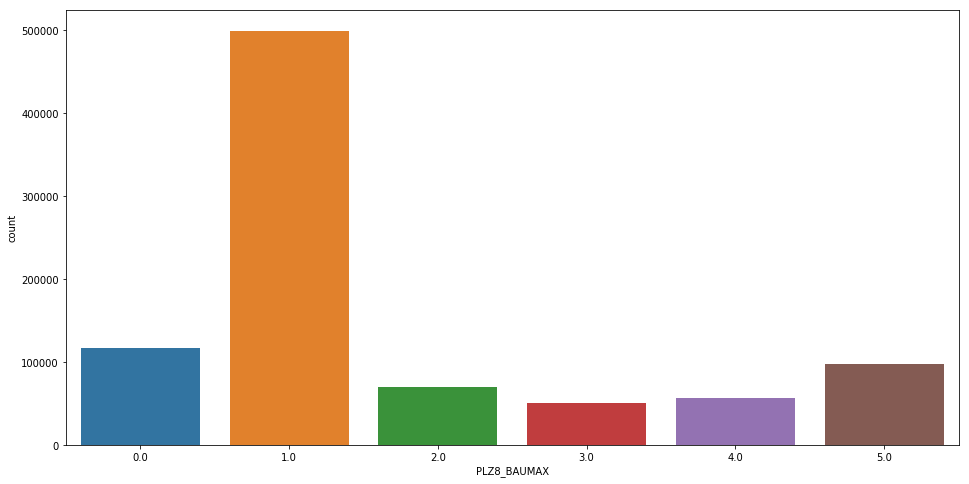

In [66]:
# visualize how much data is missing 
test = azdias_mod_4.copy()
test.PLZ8_BAUMAX = test.PLZ8_BAUMAX.replace(np.nan, 0.0);
plt.figure(figsize=(16,8))
sns.countplot(x="PLZ8_BAUMAX", data=test);

In [67]:
# how many rows have busines building
test.PLZ8_BAUMAX[(test.PLZ8_BAUMAX == 5.0)].count() / test.shape[0] * 100

10.921309080463768

In [68]:
PLZ8_BAUMAX_dict = {
    0.0: [np.nan, np.nan],
    1.0: ["1-2", 0],
    2.0: ["3-5", 0],
    3.0: ["6-10", 0],
    4.0: ["10+", 0],
    5.0: [np.nan, 1]
}

In [69]:
%%time
# change NAN values so that you can access dictonary
azdias_mod_4.PLZ8_BAUMAX = azdias_mod_4.PLZ8_BAUMAX.replace(np.nan, 0.0);
# create new collumns for decade and movement values
other = azdias_mod_4.PLZ8_BAUMAX.apply(lambda s: pd.Series({
    'PLZ8_BAUMAX_size':PLZ8_BAUMAX_dict[s][0],
    'PLZ8_BAUMAX_cell_type':PLZ8_BAUMAX_dict[s][1]}))
# add these collumns to data frame
azdias_mod_4 = azdias_mod_4.merge(other, left_index=True, right_index=True);
# drop WOHNLAGE collumn from dataframe
azdias_mod_4 = azdias_mod_4.drop(["PLZ8_BAUMAX"], axis=1);

Wall time: 7min 49s


In [70]:
# one-hot-encode WOHNLAGE score
azdias_mod_4 = azdias_mod_4.join(pd.get_dummies(azdias_mod_4["PLZ8_BAUMAX_size"],
                                                prefix="PLZ8_BAUMAX_size"))
azdias_mod_4 = azdias_mod_4.drop(["PLZ8_BAUMAX_size"], axis=1);

In [71]:
# check that all collumns were successfully one-hot-encoded
for _ in azdias_mod_4.columns:
    print(_)

ALTERSKATEGORIE_GROB
ANREDE_KZ
FINANZ_MINIMALIST
FINANZ_SPARER
FINANZ_VORSORGER
FINANZ_ANLEGER
FINANZ_UNAUFFAELLIGER
FINANZ_HAUSBAUER
GEBURTSJAHR
GREEN_AVANTGARDE
HEALTH_TYP
RETOURTYP_BK_S
SEMIO_SOZ
SEMIO_FAM
SEMIO_REL
SEMIO_MAT
SEMIO_VERT
SEMIO_LUST
SEMIO_ERL
SEMIO_KULT
SEMIO_RAT
SEMIO_KRIT
SEMIO_DOM
SEMIO_KAEM
SEMIO_PFLICHT
SEMIO_TRADV
ALTER_HH
ANZ_PERSONEN
ANZ_TITEL
HH_EINKOMMEN_SCORE
W_KEIT_KIND_HH
WOHNDAUER_2008
ANZ_HAUSHALTE_AKTIV
ANZ_HH_TITEL
KONSUMNAEHE
MIN_GEBAEUDEJAHR
KBA05_ANTG1
KBA05_ANTG2
KBA05_ANTG3
KBA05_ANTG4
KBA05_GBZ
BALLRAUM
EWDICHTE
INNENSTADT
GEBAEUDETYP_RASTER
KKK
MOBI_REGIO
ONLINE_AFFINITAET
REGIOTYP
KBA13_ANZAHL_PKW
PLZ8_ANTG1
PLZ8_ANTG2
PLZ8_ANTG3
PLZ8_ANTG4
PLZ8_HHZ
PLZ8_GBZ
ARBEIT
ORTSGR_KLS9
RELAT_AB
CJT_GESAMTTYP_1.0
CJT_GESAMTTYP_2.0
CJT_GESAMTTYP_3.0
CJT_GESAMTTYP_4.0
CJT_GESAMTTYP_5.0
CJT_GESAMTTYP_6.0
FINANZTYP_1
FINANZTYP_2
FINANZTYP_3
FINANZTYP_4
FINANZTYP_5
FINANZTYP_6
GFK_URLAUBERTYP_1.0
GFK_URLAUBERTYP_2.0
GFK_URLAUBERTYP_3.0
GFK_URLAUBERTYP_4.0
GF

#### Discussion 1.2.2: Engineer Mixed-Type Features

* Feature `PRAEGENDE_JUGENDJAHRE` was mapped into two features `decade` and `movement` using dictonary. Prior to mapping values to new features, NAN values in `PRAEGENDE_JUGENDJAHRE` were converted to 0s. `Movement` was encoded as binary categorical data 0 for "Mainstream", while 1 for "Avangarde". `decade` feature was then one-hot-encoded into multiple features.
* Feature `CAMEO_INTL_2015` mixed feature was split into two features: `wealth` and `lifespam`. First feature's data type was changed to floats, so that modulus operations could be conducted. Then both `wealth` and `lifespam` features were one=hot-encoded and `CAMEO_INTL_2015` feature was dropped.

There were 6 more mixed features, which required analysis:
* `LP_LEBENSPHASE_FEIN` had 4 dimension data, life stage (age, size of family unit, income and whatever it owns a house). Only 6 out of 40 indicated that person had house and 5 out of 40 told that person was independant, thus I grouped data into 3 new features. These features were then one-hot-encoded.
* `LP_LEBENSPHASE_GROB` contained same data as `LP_LEBENSPHASE_FEIN` just in rough scale, thus I dropped it.
* `WOHNLAGE` has two atributtes: quality and rular flag. ~20% of data has rular flag, hence two new features were created: score and rular flag. Score was one-hot-encoded, while rular flag was saved as binary [0 or 1]. 0: no score calculated entry didn't tell me whatever it is rular or not, thus I saved it as np.nan.
* `KBA05_BAUMAX` contain information about two features, whatever building is for family or business and the size of the family. Because ~11% of all data contain inforamtion whatever building is for family of for busness, I decided to keep both features. Building type was saved as binary categorical data while family size was one-hot-encoded.
* `PLZ8_BAUMAX` contains similiar information as `KBA05_BAUMAX`. Again, ~11% tell that building is busness type, hence similiar procedure as for `KBA05_BAUMAX` is done.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [72]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)


attributes = feat_info.attribute.values

print("Feature" + " "*34 + "| data type       | no. unique vlaues")
print("-"*78)
for _ in azdias_mod_4.columns:
    if _ in attributes:
        attribute_type = feat_info[feat_info.attribute == _].type.values[0]
    else:
        attribute_type = " "
        
    print("{:40s} | {:15s} | {:5s} | {}\n".format(_,attribute_type, str(azdias_mod_4[_].nunique()), azdias_mod_4[_].dtype))
    
    # break if not numerical value is found
    if azdias_mod_4[_].dtype not in [np.dtype('uint8'), np.dtype('float64'), np.dtype('int64')]:
        print("Not numerical value found")
        break

Feature                                  | data type       | no. unique vlaues
------------------------------------------------------------------------------
ALTERSKATEGORIE_GROB                     | ordinal         | 4     | float64

ANREDE_KZ                                | categorical     | 2     | int64

FINANZ_MINIMALIST                        | ordinal         | 5     | int64

FINANZ_SPARER                            | ordinal         | 5     | int64

FINANZ_VORSORGER                         | ordinal         | 5     | int64

FINANZ_ANLEGER                           | ordinal         | 5     | int64

FINANZ_UNAUFFAELLIGER                    | ordinal         | 5     | int64

FINANZ_HAUSBAUER                         | ordinal         | 5     | int64

GEBURTSJAHR                              | numeric         | 116   | float64

GREEN_AVANTGARDE                         | categorical     | 2     | int64

HEALTH_TYP                               | ordinal         | 3     | float64



NATIONALITAET_KZ_2.0                     |                 | 2     | uint8

NATIONALITAET_KZ_3.0                     |                 | 2     | uint8

SHOPPER_TYP_0.0                          |                 | 2     | uint8

SHOPPER_TYP_1.0                          |                 | 2     | uint8

SHOPPER_TYP_2.0                          |                 | 2     | uint8

SHOPPER_TYP_3.0                          |                 | 2     | uint8

SOHO_KZ_0.0                              |                 | 2     | uint8

SOHO_KZ_1.0                              |                 | 2     | uint8

VERS_TYP_1.0                             |                 | 2     | uint8

VERS_TYP_2.0                             |                 | 2     | uint8

ZABEOTYP_1                               |                 | 2     | uint8

ZABEOTYP_2                               |                 | 2     | uint8

ZABEOTYP_3                               |                 | 2     | uint8

ZABEOTYP_4  

WOHNLAGE_score_poor                      |                 | 2     | uint8

WOHNLAGE_score_very good                 |                 | 2     | uint8

WOHNLAGE_score_very poor                 |                 | 2     | uint8

KBA05_BAUMAX_cell_type                   |                 | 2     | float64

KBA05_BAUMAX_size_1-2                    |                 | 2     | uint8

KBA05_BAUMAX_size_10+                    |                 | 2     | uint8

KBA05_BAUMAX_size_3-5                    |                 | 2     | uint8

KBA05_BAUMAX_size_6-10                   |                 | 2     | uint8

PLZ8_BAUMAX_cell_type                    |                 | 2     | float64

PLZ8_BAUMAX_size_1-2                     |                 | 2     | uint8

PLZ8_BAUMAX_size_10+                     |                 | 2     | uint8

PLZ8_BAUMAX_size_3-5                     |                 | 2     | uint8

PLZ8_BAUMAX_size_6-10                    |                 | 2     | uint8



#### All values are numerical. Categorical unprocessed features have only two values, all other on-hot enocded features have 2 values as well.

In [73]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



#### After on-hot encoding, original features were allways droped, hence no additional processing is required.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

## Added additional input parameter to function

In [26]:
def clean_data(df, df_feat):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame, Feature info DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    
    Use dictonaries as GLOBAL variables
    """
    
    global PRAEGENDE_JUGENDJAHRE_dict, LP_LEBENSPHASE_FEIN_dict, WOHNLAGE_dict, KBA05_BAUMAX_dict, PLZ8_BAUMAX_dict
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    # I need feat_info dataframe
    df_mod = remove_nan(df, df_feat)
    
    # remove selected columns and rows, AGER_TYP and TITEL_KZ collumns were selected to be removed because too many NAN
    df_mod = df_mod.drop(["AGER_TYP", "TITEL_KZ"], axis=1)
    # remove rought features
    df_mod = df_mod.drop(["LP_FAMILIE_GROB", "LP_STATUS_GROB", "CAMEO_DEUG_2015", "LP_LEBENSPHASE_GROB"], axis=1)
    
    # select, re-encode, and engineer column values.
    df_mod = one_hot_encode(df_mod, df_feat, drop_col= False)
    
    # process MIXED features
    
    # replace NaN value with 0 so it can be used as dictonary key
    df_mod.PRAEGENDE_JUGENDJAHRE = df_mod.PRAEGENDE_JUGENDJAHRE.replace(np.nan, 0.0)
    
    # create new collumns for decade and movement values
    other = df_mod.PRAEGENDE_JUGENDJAHRE.apply(lambda s: pd.Series({
        'PRAEGENDE_JUGENDJAHRE_decade':PRAEGENDE_JUGENDJAHRE_dict[s][0],
        'PRAEGENDE_JUGENDJAHRE_movement':PRAEGENDE_JUGENDJAHRE_dict[s][1]}))
    # add these collumns to data frame
    df_mod = df_mod.merge(other, left_index=True, right_index=True)
    # drop PRAEGENDE_JUGENDJAHRE collumn from dataframe
    df_mod = df_mod.drop(["PRAEGENDE_JUGENDJAHRE"], axis=1)
    # one-hot-encode decade data
    df_mod = df_mod.join(pd.get_dummies(df_mod["PRAEGENDE_JUGENDJAHRE_decade"],
                                                    prefix="PRAEGENDE_JUGENDJAHRE_decade"))
    # drop PRAEGENDE_JUGENDJAHRE_decade collumn from dataframe
    df_mod = df_mod.drop(["PRAEGENDE_JUGENDJAHRE_decade"], axis=1)
    print("{:20s} feature processed".format("PRAEGENDE_JUGENDJAHRE"))
    
    
    # convert to float values for numerical encoding
    df_mod.CAMEO_INTL_2015 = df_mod.CAMEO_INTL_2015.astype('float')

    # create new collumns for decade and movement values
    other = df_mod.CAMEO_INTL_2015.apply(lambda s: pd.Series({
        'CAMEO_INTL_2015_wealth':s//10,
        'CAMEO_INTL_2015_lifestage':s%10}))
    # add these collumns to data frame
    df_mod = df_mod.merge(other, left_index=True, right_index=True);
    # drop CAMEO_INTL_2015 collumn from dataframe
    df_mod = df_mod.drop(["CAMEO_INTL_2015"], axis=1);
    # one-hot-encode wealth and lifestage data
    df_mod = df_mod.join(pd.get_dummies(df_mod["CAMEO_INTL_2015_wealth"],
                                                    prefix="CAMEO_INTL_2015_wealth"))
    df_mod = df_mod.join(pd.get_dummies(df_mod["CAMEO_INTL_2015_lifestage"],
                                                    prefix="CAMEO_INTL_2015_lifestage"))
    # drop one-hot-encoded original collumns
    df_mod = df_mod.drop(["CAMEO_INTL_2015_wealth"], axis=1);
    df_mod = df_mod.drop(["CAMEO_INTL_2015_lifestage"], axis=1);
    print("{:20s} feature processed".format("CAMEO_INTL_2015"))
    
    # change NAN values so that you can access dictonary
    df_mod.LP_LEBENSPHASE_FEIN = df_mod.LP_LEBENSPHASE_FEIN.replace(np.nan, 0.0);
    # create new collumns for decade and movement values
    other = df_mod.LP_LEBENSPHASE_FEIN.apply(lambda s: pd.Series({
        'LP_LEBENSPHASE_FEIN_type':LP_LEBENSPHASE_FEIN_dict[s][0],
        'LP_LEBENSPHASE_FEIN_income':LP_LEBENSPHASE_FEIN_dict[s][1],
        'LP_LEBENSPHASE_FEIN_age':LP_LEBENSPHASE_FEIN_dict[s][2]}))
    # add these collumns to data frame
    df_mod = df_mod.merge(other, left_index=True, right_index=True);
    # drop LP_LEBENSPHASE_FEIN collumn from dataframe
    df_mod = df_mod.drop(["LP_LEBENSPHASE_FEIN"], axis=1)
    # one-hot-encode type, income and age
    df_mod = df_mod.join(pd.get_dummies(df_mod["LP_LEBENSPHASE_FEIN_type"],
                                                    prefix="LP_LEBENSPHASE_FEIN_type"))
    df_mod = df_mod.drop(["LP_LEBENSPHASE_FEIN_type"], axis=1);

    df_mod = df_mod.join(pd.get_dummies(df_mod["LP_LEBENSPHASE_FEIN_income"],
                                                    prefix="LP_LEBENSPHASE_FEIN_income"))
    df_mod = df_mod.drop(["LP_LEBENSPHASE_FEIN_income"], axis=1);

    df_mod = df_mod.join(pd.get_dummies(df_mod["LP_LEBENSPHASE_FEIN_age"],
                                                    prefix="LP_LEBENSPHASE_FEIN_age"))
    df_mod = df_mod.drop(["LP_LEBENSPHASE_FEIN_age"], axis=1);
    
    print("{:20s} feature processed".format("LP_LEBENSPHASE_FEIN"))

    # change NAN values so that you can access dictonary
    df_mod.WOHNLAGE = df_mod.WOHNLAGE.replace(np.nan, -1.0)
    # create new collumns for decade and movement values
    other = df_mod.WOHNLAGE.apply(lambda s: pd.Series({
        'WOHNLAGE_score':WOHNLAGE_dict[s][0],
        'WOHNLAGE_score_rular':WOHNLAGE_dict[s][1]}))
    # add these collumns to data frame
    df_mod = df_mod.merge(other, left_index=True, right_index=True)
    # drop WOHNLAGE collumn from dataframe
    df_mod = df_mod.drop(["WOHNLAGE"], axis=1)
    # one-hot-encode WOHNLAGE score
    df_mod = df_mod.join(pd.get_dummies(df_mod["WOHNLAGE_score"],
                                                    prefix="WOHNLAGE_score"))
    df_mod = df_mod.drop(["WOHNLAGE_score"], axis=1);
    
    print("{:20s} feature processed".format("WOHNLAGE"))
    
    # change NAN values so that you can access dictonary
    df_mod.KBA05_BAUMAX = df_mod.KBA05_BAUMAX.replace(np.nan, 0.0);
    # create new collumns for decade and movement values
    other = df_mod.KBA05_BAUMAX.apply(lambda s: pd.Series({
        'KBA05_BAUMAX_size':KBA05_BAUMAX_dict[s][0],
        'KBA05_BAUMAX_cell_type':KBA05_BAUMAX_dict[s][1]}))
    # add these collumns to data frame
    df_mod = df_mod.merge(other, left_index=True, right_index=True);
    # drop KBA05_BAUMAX collumn from dataframe
    df_mod = df_mod.drop(["KBA05_BAUMAX"], axis=1);
    
    # one-hot-encode KBA05_BAUMAX size
    df_mod = df_mod.join(pd.get_dummies(df_mod["KBA05_BAUMAX_size"],
                                                    prefix="KBA05_BAUMAX_size"))
    df_mod = df_mod.drop(["KBA05_BAUMAX_size"], axis=1)
    print("{:20s} feature processed".format("KBA05_BAUMAX"))

    # change NAN values so that you can access dictonary
    df_mod.PLZ8_BAUMAX = df_mod.PLZ8_BAUMAX.replace(np.nan, 0.0);
    # create new collumns for decade and movement values
    other = df_mod.PLZ8_BAUMAX.apply(lambda s: pd.Series({
        'PLZ8_BAUMAX_size':PLZ8_BAUMAX_dict[s][0],
        'PLZ8_BAUMAX_cell_type':PLZ8_BAUMAX_dict[s][1]}))
    # add these collumns to data frame
    df_mod = df_mod.merge(other, left_index=True, right_index=True)
    # one-hot-encode PLZ8_BAUMAX score
    df_mod = df_mod.join(pd.get_dummies(df_mod["PLZ8_BAUMAX_size"],
                                                    prefix="PLZ8_BAUMAX_size"))
    df_mod = df_mod.drop(["PLZ8_BAUMAX_size"], axis=1)
    
    # drop PLZ8_BAUMAX collumn from dataframe
    df_mod = df_mod.drop(["PLZ8_BAUMAX"], axis=1)
    print("{:20s} feature processed".format("PLZ8_BAUMAX"))
    
    # Return the cleaned dataframe.
    return df_mod    

### Supporting dictonaries


In [27]:
PRAEGENDE_JUGENDJAHRE_dict = {
    0.0: [np.nan, np.nan],
    1.0: ["40s", 0],
    2.0: ["40s", 1],
    3.0: ["50s", 0],
    4.0: ["50s", 1],
    5.0: ["60s", 0],
    6.0: ["60s", 1],
    7.0: ["60s", 1],
    8.0: ["70s", 0],
    9.0: ["70s", 1],
    10.0: ["80s", 0],
    11.0: ["80s", 1],
    12.0: ["80s", 0],
    13.0: ["80s", 1],
    14.0: ["90s", 0],
    15.0: ["90s", 1]
}

LP_LEBENSPHASE_FEIN_dict = {
    0.0: [np.nan, np.nan, np.nan],
    1.0: ["single", "low", "young"],
    2.0: ["single", "low", "middle"],
    3.0: ["single", "average", "young"],
    4.0: ["single", "average", "middle"],
    5.0: ["single", "low", "advanced"],
    6.0: ["single", "low", "retirement"],
    7.0: ["single", "average", "advanced"],
    8.0: ["single", "average", "retirement"],
    9.0: ['single', np.nan, np.nan],
    10.0: ['single_home', 'high', np.nan],
    11.0: ['single_home', np.nan, "advanced"],
    12.0: ['single_home', np.nan, "retirement"],
    13.0: ['single', 'high', "higher"],
    14.0: ["couple", 'average', 'young'],
    15.0: ["couple", "low", 'higher'],
    16.0: ['couple', "average", "higher"],
    17.0: ['couple', np.nan, np.nan],
    18.0: ['couple', 'high', 'young'],
    19.0: ['couple', np.nan, "higher"],
    20.0: ['couple', 'high', "higher"],
    21.0: ['single_parent', 'low', np.nan],
    22.0: ['single_parent', 'average', np.nan],
    23.0: ['single_parent', 'high', np.nan],
    24.0: ['family', 'low', np.nan],
    25.0: ['family', 'average', np.nan],
    26.0: ['family', np.nan, np.nan],
    27.0: ['family', np.nan, np.nan],
    28.0: ['family', 'high', np.nan],
    29.0: ['multi', 'low', 'young'],
    30.0: ['multi', 'average', 'young'],
    31.0: ['multi', 'low', 'higher'],
    32.0: ['multi', 'average', 'higher'],
    33.0: ['multi', np.nan , 'young'],
    34.0: ['multi', np.nan , 'young'],
    35.0: ['multi', 'high' , 'young'],
    36.0: ['multi', np.nan , 'higher'],
    37.0: ['multi', np.nan , 'advanced'],
    38.0: ['multi', np.nan , 'retirement'],
    39.0: ['multi', 'high' , 'middle'],
    40.0: ['multi', 'high' , 'retirement']    
}

WOHNLAGE_dict = {
    -1.0: [np.nan, np.nan],
    0.0: [np.nan, np.nan],
    1.0: ["very good", 0],
    2.0: ["good", 0],
    3.0: ["average", 0],
    4.0: ["poor", 0],
    5.0: ["very poor", 0],
    7.0: [np.nan, 1],
    8.0: ["new building", 1]
}

KBA05_BAUMAX_dict = {
    0.0: [np.nan, np.nan],
    1.0: ["1-2", 0],
    2.0: ["3-5", 0],
    3.0: ["6-10", 0],
    4.0: ["10+", 0],
    5.0: [np.nan, 1]
}

PLZ8_BAUMAX_dict = {
    0.0: [np.nan, np.nan],
    1.0: ["1-2", 0],
    2.0: ["3-5", 0],
    3.0: ["6-10", 0],
    4.0: ["10+", 0],
    5.0: [np.nan, 1]
}

In [28]:
%%time

azdias_mod = clean_data(azdias, feat_info)

CJT_GESAMTTYP        feature one-hot-encoded
FINANZTYP            feature one-hot-encoded
GFK_URLAUBERTYP      feature one-hot-encoded
LP_FAMILIE_FEIN      feature one-hot-encoded
LP_STATUS_FEIN       feature one-hot-encoded
NATIONALITAET_KZ     feature one-hot-encoded
SHOPPER_TYP          feature one-hot-encoded
SOHO_KZ              feature one-hot-encoded
VERS_TYP             feature one-hot-encoded
ZABEOTYP             feature one-hot-encoded
KK_KUNDENTYP         feature one-hot-encoded
GEBAEUDETYP          feature one-hot-encoded
OST_WEST_KZ          feature one-hot-encoded
CAMEO_DEU_2015       feature one-hot-encoded
PRAEGENDE_JUGENDJAHRE feature processed
CAMEO_INTL_2015      feature processed
LP_LEBENSPHASE_FEIN  feature processed
WOHNLAGE             feature processed
KBA05_BAUMAX         feature processed
PLZ8_BAUMAX          feature processed
Wall time: 51min 24s


In [29]:
azdias_mod.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,...,KBA05_BAUMAX_cell_type,KBA05_BAUMAX_size_1-2,KBA05_BAUMAX_size_10+,KBA05_BAUMAX_size_3-5,KBA05_BAUMAX_size_6-10,PLZ8_BAUMAX_cell_type,PLZ8_BAUMAX_size_1-2,PLZ8_BAUMAX_size_10+,PLZ8_BAUMAX_size_3-5,PLZ8_BAUMAX_size_6-10
0,2.0,1,3,4,3,5,5,3,NaN,0,...,NaN,0,0,0,0,NaN,0,0,0,0
1,1.0,2,1,5,2,5,4,5,1996.0,0,...,1.0,0,0,0,0,0.0,1,0,0,0
2,3.0,2,1,4,1,2,3,5,1979.0,1,...,NaN,0,0,0,0,0.0,1,0,0,0
3,4.0,2,4,2,5,2,1,2,1957.0,0,...,0.0,1,0,0,0,0.0,1,0,0,0
4,3.0,1,4,3,4,1,3,2,1963.0,0,...,NaN,0,0,0,0,0.0,0,0,1,0


## check that function works corectly on original data

In [30]:
attributes = feat_info.attribute.values

print("Feature" + " "*34 + "| data type       | no. unique vlaues")
print("-"*78)
for _ in azdias_mod.columns:
    if _ in attributes:
        attribute_type = feat_info[feat_info.attribute == _].type.values[0]
    else:
        attribute_type = " "
        
    print("{:40s} | {:15s} | {:5s} | {}\n".format(_,attribute_type, str(azdias_mod[_].nunique()), azdias_mod[_].dtype))
    
    # break if not numerical value is found
    if azdias_mod[_].dtype not in [np.dtype('uint8'), np.dtype('float64'), np.dtype('int64')]:
        print("Not numerical value found")
        break

Feature                                  | data type       | no. unique vlaues
------------------------------------------------------------------------------
ALTERSKATEGORIE_GROB                     | ordinal         | 4     | float64

ANREDE_KZ                                | categorical     | 2     | int64

FINANZ_MINIMALIST                        | ordinal         | 5     | int64

FINANZ_SPARER                            | ordinal         | 5     | int64

FINANZ_VORSORGER                         | ordinal         | 5     | int64

FINANZ_ANLEGER                           | ordinal         | 5     | int64

FINANZ_UNAUFFAELLIGER                    | ordinal         | 5     | int64

FINANZ_HAUSBAUER                         | ordinal         | 5     | int64

GEBURTSJAHR                              | numeric         | 116   | float64

GREEN_AVANTGARDE                         | categorical     | 2     | int64

HEALTH_TYP                               | ordinal         | 3     | float64



NATIONALITAET_KZ_2.0                     |                 | 2     | uint8

NATIONALITAET_KZ_3.0                     |                 | 2     | uint8

SHOPPER_TYP_0.0                          |                 | 2     | uint8

SHOPPER_TYP_1.0                          |                 | 2     | uint8

SHOPPER_TYP_2.0                          |                 | 2     | uint8

SHOPPER_TYP_3.0                          |                 | 2     | uint8

SOHO_KZ_0.0                              |                 | 2     | uint8

SOHO_KZ_1.0                              |                 | 2     | uint8

VERS_TYP_1.0                             |                 | 2     | uint8

VERS_TYP_2.0                             |                 | 2     | uint8

ZABEOTYP_1                               |                 | 2     | uint8

ZABEOTYP_2                               |                 | 2     | uint8

ZABEOTYP_3                               |                 | 2     | uint8

ZABEOTYP_4  

WOHNLAGE_score_very good                 |                 | 2     | uint8

WOHNLAGE_score_very poor                 |                 | 2     | uint8

KBA05_BAUMAX_cell_type                   |                 | 2     | float64

KBA05_BAUMAX_size_1-2                    |                 | 2     | uint8

KBA05_BAUMAX_size_10+                    |                 | 2     | uint8

KBA05_BAUMAX_size_3-5                    |                 | 2     | uint8

KBA05_BAUMAX_size_6-10                   |                 | 2     | uint8

PLZ8_BAUMAX_cell_type                    |                 | 2     | float64

PLZ8_BAUMAX_size_1-2                     |                 | 2     | uint8

PLZ8_BAUMAX_size_10+                     |                 | 2     | uint8

PLZ8_BAUMAX_size_3-5                     |                 | 2     | uint8

PLZ8_BAUMAX_size_6-10                    |                 | 2     | uint8



## check that function works corectly on Udacity customer subset data

In [79]:
azdias_customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv",delimiter=";")

In [80]:
print("AZDIAS customers dataframe size\nrows: {}\ncols: {}".format(*azdias_customers.shape))

AZDIAS customers dataframe size
rows: 191652
cols: 85


In [81]:
%%time

azdias_customers_mod = clean_data(azdias_customers, feat_info)

CJT_GESAMTTYP        feature one-hot-encoded
FINANZTYP            feature one-hot-encoded
GFK_URLAUBERTYP      feature one-hot-encoded
LP_FAMILIE_FEIN      feature one-hot-encoded
LP_STATUS_FEIN       feature one-hot-encoded
NATIONALITAET_KZ     feature one-hot-encoded
SHOPPER_TYP          feature one-hot-encoded
SOHO_KZ              feature one-hot-encoded
VERS_TYP             feature one-hot-encoded
ZABEOTYP             feature one-hot-encoded
KK_KUNDENTYP         feature one-hot-encoded
GEBAEUDETYP          feature one-hot-encoded
OST_WEST_KZ          feature one-hot-encoded
CAMEO_DEU_2015       feature one-hot-encoded
PRAEGENDE_JUGENDJAHRE feature processed
CAMEO_INTL_2015      feature processed
LP_LEBENSPHASE_FEIN  feature processed
WOHNLAGE             feature processed
KBA05_BAUMAX         feature processed
PLZ8_BAUMAX          feature processed
Wall time: 10min 23s


In [82]:
attributes = feat_info.attribute.values

print("Feature" + " "*34 + "| data type       | no. unique vlaues")
print("-"*78)
for _ in azdias_customers_mod.columns:
    if _ in attributes:
        attribute_type = feat_info[feat_info.attribute == _].type.values[0]
    else:
        attribute_type = " "
        
    print("{:40s} | {:15s} | {:5s} | {}\n".format(_,attribute_type, str(azdias_customers_mod[_].nunique()),
                                                  azdias_customers_mod[_].dtype))
    
    # break if not numerical value is found
    if azdias_customers_mod[_].dtype not in [np.dtype('uint8'), np.dtype('float64'), np.dtype('int64')]:
        print("Not numerical value found")
        break

Feature                                  | data type       | no. unique vlaues
------------------------------------------------------------------------------
ALTERSKATEGORIE_GROB                     | ordinal         | 4     | float64

ANREDE_KZ                                | categorical     | 2     | int64

FINANZ_MINIMALIST                        | ordinal         | 5     | int64

FINANZ_SPARER                            | ordinal         | 5     | int64

FINANZ_VORSORGER                         | ordinal         | 5     | int64

FINANZ_ANLEGER                           | ordinal         | 5     | int64

FINANZ_UNAUFFAELLIGER                    | ordinal         | 5     | int64

FINANZ_HAUSBAUER                         | ordinal         | 5     | int64

GEBURTSJAHR                              | numeric         | 112   | float64

GREEN_AVANTGARDE                         | categorical     | 2     | int64

HEALTH_TYP                               | ordinal         | 3     | float64



SHOPPER_TYP_0.0                          |                 | 2     | uint8

SHOPPER_TYP_1.0                          |                 | 2     | uint8

SHOPPER_TYP_2.0                          |                 | 2     | uint8

SHOPPER_TYP_3.0                          |                 | 2     | uint8

SOHO_KZ_0.0                              |                 | 2     | uint8

SOHO_KZ_1.0                              |                 | 2     | uint8

VERS_TYP_1.0                             |                 | 2     | uint8

VERS_TYP_2.0                             |                 | 2     | uint8

ZABEOTYP_1                               |                 | 2     | uint8

ZABEOTYP_2                               |                 | 2     | uint8

ZABEOTYP_3                               |                 | 2     | uint8

ZABEOTYP_4                               |                 | 2     | uint8

ZABEOTYP_5                               |                 | 2     | uint8

ZABEOTYP_6  

WOHNLAGE_score_very poor                 |                 | 2     | uint8

KBA05_BAUMAX_cell_type                   |                 | 2     | float64

KBA05_BAUMAX_size_1-2                    |                 | 2     | uint8

KBA05_BAUMAX_size_10+                    |                 | 2     | uint8

KBA05_BAUMAX_size_3-5                    |                 | 2     | uint8

KBA05_BAUMAX_size_6-10                   |                 | 2     | uint8

PLZ8_BAUMAX_cell_type                    |                 | 2     | float64

PLZ8_BAUMAX_size_1-2                     |                 | 2     | uint8

PLZ8_BAUMAX_size_10+                     |                 | 2     | uint8

PLZ8_BAUMAX_size_3-5                     |                 | 2     | uint8

PLZ8_BAUMAX_size_6-10                    |                 | 2     | uint8



In [83]:
for _ in azdias_mod.columns.values:
    if _ not in azdias_customers_mod.columns.values:
        print(_)

GEBAEUDETYP_5.0


#### Seems like function works on both data frames, but on customer data one collumn is not created.
Quick fix/dirty solution will be to add `GEBAEUDETYP_5.0` collumn with 0 values to customer data.

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [31]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# total missing data in processed DataFrame
total_nan = azdias_mod.isna().sum().sum()
total = azdias_mod.shape[0] * azdias_mod.shape[1]
print("Total misssing data {:.2f} %".format(total_nan/total*100))

Total misssing data 2.44 %


In [32]:
# remove all rows which contain atleast one nan value
azdias_mod_no_nan = azdias_mod.dropna()
total_no_nan = azdias_mod_no_nan.shape[0] * azdias_mod_no_nan.shape[1]
print("{:.2f} % of data left after removing all rows containing atleast one NAN".format(total_no_nan/total*100))

21.78 % of data left after removing all rows containing atleast one NAN


In [33]:
# check how much data variations and means differ between dataframe with removed NAN and all values
std_mean_list = list()
index_list = list()
for _ in azdias_mod.columns.values:
    std_mean_list.append([azdias_mod[_].std(), azdias_mod_no_nan[_].std(),
                         azdias_mod[_].mean(), azdias_mod_no_nan[_].mean()
                         ])
    index_list.append(_)

In [34]:
# create dataframe with STD and MEAN values. o stands for original and n for no NAN
df_std_mean = pd.DataFrame(std_mean_list, index= index_list, columns= ["STD_o", "STD_n", "Mean_o", "Mean_n"])

In [35]:
df_std_mean["STD_ratio"] = df_std_mean.STD_n / df_std_mean.STD_o
df_std_mean["Mean_ratio"] = df_std_mean.Mean_n / df_std_mean.Mean_o

In [36]:
df_std_mean.head()

,STD_o,STD_n,Mean_o,Mean_n,STD_ratio,Mean_ratio
ALTERSKATEGORIE_GROB,1.009951,1.020786,2.757217,2.768726,1.010729,1.004174
ANREDE_KZ,0.499512,0.499807,1.522098,1.513920,1.000592,0.994627
FINANZ_MINIMALIST,1.321055,1.376281,3.074528,3.155652,1.041804,1.026386
FINANZ_SPARER,1.464749,1.461989,2.821039,2.683399,0.998116,0.951210
FINANZ_VORSORGER,1.322134,1.425106,3.401106,3.386911,1.077883,0.995826


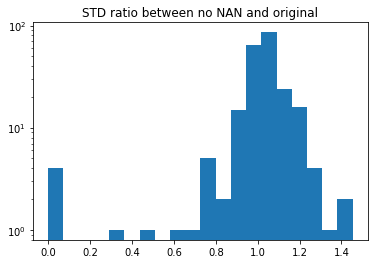

In [37]:
plt.hist(df_std_mean.STD_ratio, bins=20, log=True);
plt.title("STD ratio between no NAN and original");

In [38]:
df_std_mean[df_std_mean.STD_ratio<0.5]

,STD_o,STD_n,Mean_o,Mean_n,STD_ratio,Mean_ratio
MIN_GEBAEUDEJAHR,3.332739,1.545497,1993.277011,1992.523347,0.463732,0.999622
SOHO_KZ_0.0,0.286466,0.093010,0.909801,0.991273,0.324679,1.089549
GEBAEUDETYP_2.0,0.074207,0.000000,0.005537,0.000000,0.000000,0.000000
GEBAEUDETYP_4.0,0.031762,0.000000,0.001010,0.000000,0.000000,0.000000
GEBAEUDETYP_5.0,0.001059,0.000000,0.000001,0.000000,0.000000,0.000000
GEBAEUDETYP_6.0,0.026536,0.000000,0.000705,0.000000,0.000000,0.000000


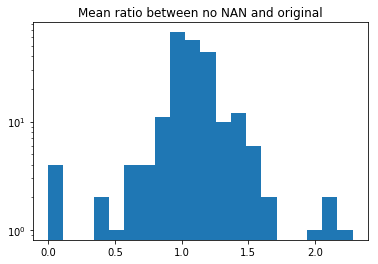

In [39]:
plt.hist(df_std_mean.Mean_ratio, bins=20, log=True);
plt.title("Mean ratio between no NAN and original");

In [40]:
df_std_mean[(df_std_mean.Mean_ratio<0.5) | (df_std_mean.Mean_ratio>2.0)]

,STD_o,STD_n,Mean_o,Mean_n,STD_ratio,Mean_ratio
LP_STATUS_FEIN_5.0,0.276765,0.184445,0.083585,0.035263,0.666430,0.421882
GEBAEUDETYP_2.0,0.074207,0.000000,0.005537,0.000000,0.000000,0.000000
GEBAEUDETYP_4.0,0.031762,0.000000,0.001010,0.000000,0.000000,0.000000
GEBAEUDETYP_5.0,0.001059,0.000000,0.000001,0.000000,0.000000,0.000000
GEBAEUDETYP_6.0,0.026536,0.000000,0.000705,0.000000,0.000000,0.000000
WOHNLAGE_score_new building,0.138641,0.086282,0.019606,0.007501,0.622342,0.382584
KBA05_BAUMAX_size_1-2,0.423282,0.498834,0.233856,0.534150,1.178491,2.284104
KBA05_BAUMAX_size_3-5,0.103672,0.150646,0.010866,0.023234,1.453102,2.138232
KBA05_BAUMAX_size_6-10,0.250494,0.350336,0.067273,0.143258,1.398580,2.129499


In [41]:
# Apply feature scaling to the general population demographics data.

# create scaler
scaler = p.StandardScaler()
# scale data with no NAN values
scaler.fit(azdias_mod_no_nan)
# create new dataframe using scaller
azdias_mod_ss = pd.DataFrame(scaler.transform(azdias_mod_no_nan), columns = azdias_mod.columns.values)

C:\Users\Tomas\PycharmProjects\nano_degree_DS\venv\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Tomas\PycharmProjects\nano_degree_DS\venv\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  


In [42]:
azdias_mod_ss.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,...,KBA05_BAUMAX_cell_type,KBA05_BAUMAX_size_1-2,KBA05_BAUMAX_size_10+,KBA05_BAUMAX_size_3-5,KBA05_BAUMAX_size_6-10,PLZ8_BAUMAX_cell_type,PLZ8_BAUMAX_size_1-2,PLZ8_BAUMAX_size_10+,PLZ8_BAUMAX_size_3-5,PLZ8_BAUMAX_size_6-10
0,0.226565,0.972537,-0.839694,-0.467446,1.131911,0.161610,-1.160818,1.428788,-1.438592,-0.618605,...,-0.524123,-1.070801,-0.302537,6.483853,-0.408915,-0.423247,-1.335801,-0.294688,3.727144,-0.253029
1,-1.732715,-1.028238,1.340099,0.900557,-0.973201,0.161610,0.996284,-1.444211,0.900008,1.616540,...,-0.524123,0.933880,-0.302537,-0.154229,-0.408915,-0.423247,0.748614,-0.294688,-0.268302,-0.253029
2,-0.753075,0.972537,-0.839694,-0.467446,0.430207,-1.237859,0.277250,0.710539,-0.183734,-0.618605,...,1.907951,-1.070801,-0.302537,-0.154229,-0.408915,2.362689,-1.335801,-0.294688,-0.268302,-0.253029
3,1.206205,-1.028238,1.340099,-1.151448,1.131911,-1.237859,-1.160818,-0.007711,-0.525968,-0.618605,...,-0.524123,0.933880,-0.302537,-0.154229,-0.408915,-0.423247,0.748614,-0.294688,-0.268302,-0.253029
4,-1.732715,0.972537,-0.839694,1.584559,-0.271497,1.561079,1.715318,-0.725961,1.356320,1.616540,...,-0.524123,0.933880,-0.302537,-0.154229,-0.408915,-0.423247,0.748614,-0.294688,-0.268302,-0.253029


### Discussion 2.1: Apply Feature Scaling

* My idea was to drop all rows containing NAN values and then use this dataframe with standard scaller. Having only 21.78 % of data might have an affect on variation.
* For this reason I investigted how much data variation of each column difference between FULL DataFrame and Dataframe without NAN values. Some collums, after removing rows with NAN had no 1 values, hence their variation was 0. I found 4 features with 0 variation and 2 features with variations, which were >2 times larger than original (ratio <0.5). I also checked how much mean values differ between these dataset. Same columns with no 1 values would have mean=0, while 3 collumns with no NAN had >2 larger mean values.
* Al these collumns came from one-hot-encoding. There is no legitimate way to Impute them. Substituting to 0 or 1, or using mean, would distort data, hence I chose to use stadardscaler on dataframe with removed values directly and then transform Dataframe with NAN values with it.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [43]:
# Apply PCA to the data.

var_list = list()
comp_list= list()

for _ in [30, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 160, 180, 200, 228]:
    pca = PCA(_)
    X_pca = pca.fit_transform(azdias_mod_ss)
    var = np.sum(pca.explained_variance_ratio_)
    var_list.append(var)
    comp_list.append(_)

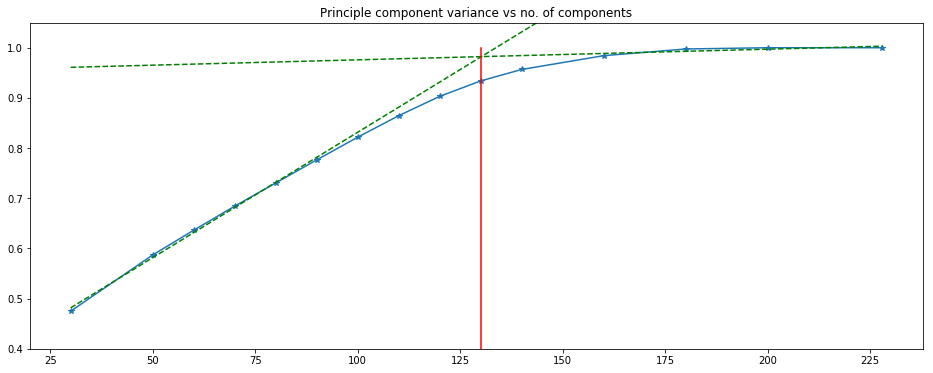

In [44]:
# fit segments of PCA variance results
p1 = np.polyfit(comp_list[:6], var_list[:6], deg=1)
p2 = np.polyfit(comp_list[11:15], var_list[11:15], deg=1)

x = np.array(comp_list)
y1 = p1[1] + p1[0] * np.array(comp_list)
y2 = p2[1] + p2[0] * np.array(comp_list)



plt.figure(figsize=(16,6))
plt.plot(comp_list, var_list, "*-");
plt.title("Principle component variance vs no. of components")
plt.plot(x, y1, 'g--')
plt.plot(x, y2, 'g--')
plt.plot([130, 130],[0,1],"r-")
plt.ylim(0.4,1.05);

In [43]:
# Re-apply PCA to the data while selecting for number of components to retain.

# I chose to use 130 components, which reduces component number by 42%, while retaining >90% variance
pca = PCA(130)
azdias_mod_ss_pca = pca.fit_transform(azdias_mod_ss)
var = np.sum(pca.explained_variance_ratio_)
print("Variance: {}".format(var))

Variance: 0.9336234957503287


In [44]:
def scree_plot(pca, comp_start = 0, comp_end = 10):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_) #comp_end-comp_start
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(16, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    
    ax.bar(ind[comp_start:comp_end], vals[comp_start:comp_end], alpha=0.5)
    ax.plot(ind[comp_start:comp_end], cumvals[comp_start:comp_end], "r--", alpha=0.5)
    for i in list(range(comp_start, comp_end)): #range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component (Range {}-{} components)'.format(comp_start, comp_end))

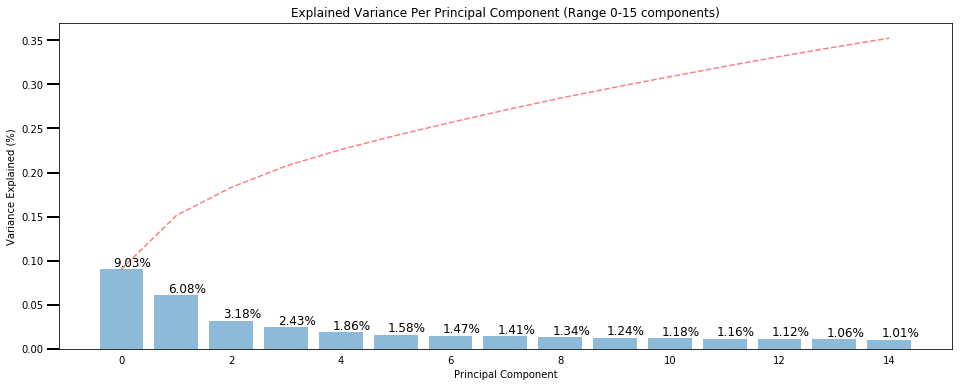

In [45]:
# check first 15 components
scree_plot(pca, comp_start = 0, comp_end = 15)

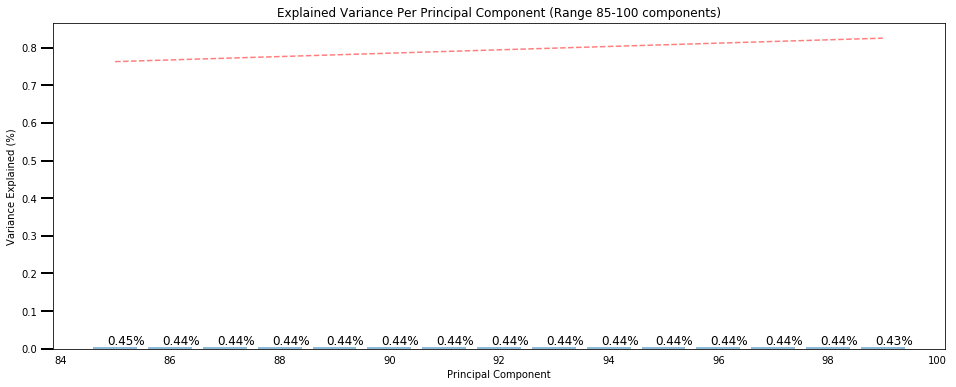

In [46]:
# check last 15 components
scree_plot(pca, comp_start = 85, comp_end = 100)

### Discussion 2.2: Perform Dimensionality Reduction

* I ran FOR loop using different number of PCA components. Variance explained by components had double slope shape. By lienarly fiting these two slopes, I found that 129 components allows me to recuce dimensionality by 43% while retaining 93% variance. 
* First principle component explains 9% variance while, last compoentns account for only 0.4% each.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [47]:
# function used to find weights.
def analyze_component(df, pca, comp, top=5):
    '''
    Plots an image associated with each component to understand how the weighting 
    of the components 
    INPUT: 
          df - Dataframe on which PCA was done
          pca - pca object created from PCA in sklearn
          comp - int - the component you want to see starting at 0
          
    OUTPUT
          None
    '''
    if comp <= len(pca.components_):
        # create Dataframe for PCA weighs for each feature
        df = pd.DataFrame(np.array([df.columns.values, pca.components_[comp]]).T, columns=["Feature", "Weight"])
        # convert weights to floats
        df["Weight"] = df["Weight"].astype("float64")
        # get top positive and negative features
        df_p = df.nlargest(top, 'Weight')
        df_n = df.nsmallest(top, 'Weight')
        df["Weight"] = df["Weight"].abs()
        df_abs = df.nlargest(top, 'Weight')
        df_list = [df_p, df_n, df_abs]
        
        fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16,20))
        names = ["Top {} positive features".format(top),
                 "Top {} negative features".format(top),
                "Top {} absolute features".format(top)]
        for ax, index in zip(axes.flatten(), range(3)):
            sns.barplot(y="Feature", x="Weight", data=df_list[index], ax=ax).set_title(names[index])        
    else:
        print('{} components are available, you asked for {} compoent which is out of range'.format(len(pca.components_) ,comp))

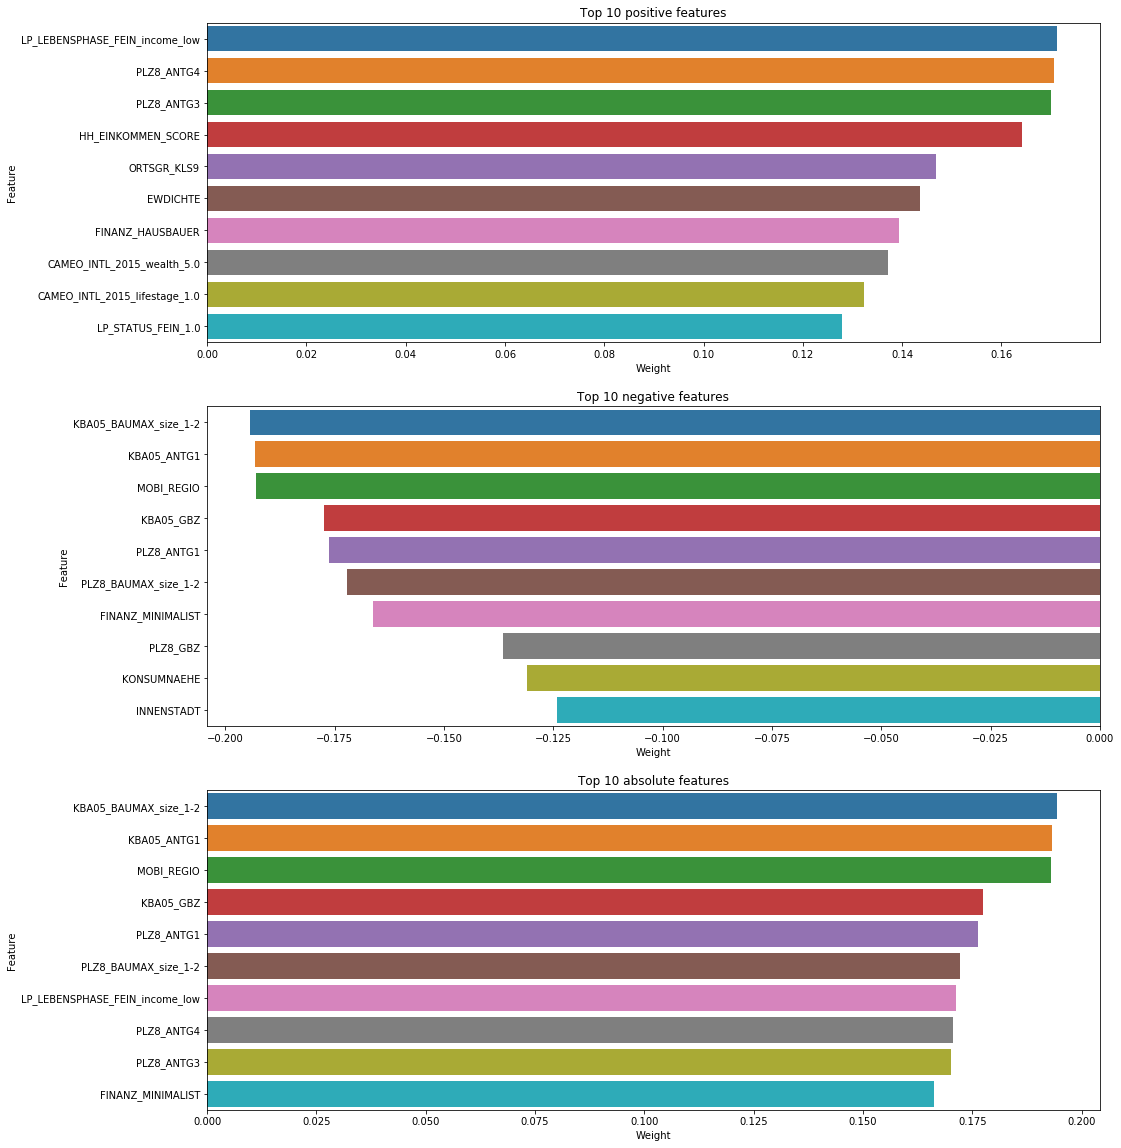

In [48]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

analyze_component(azdias_mod, pca, 0, top=10)

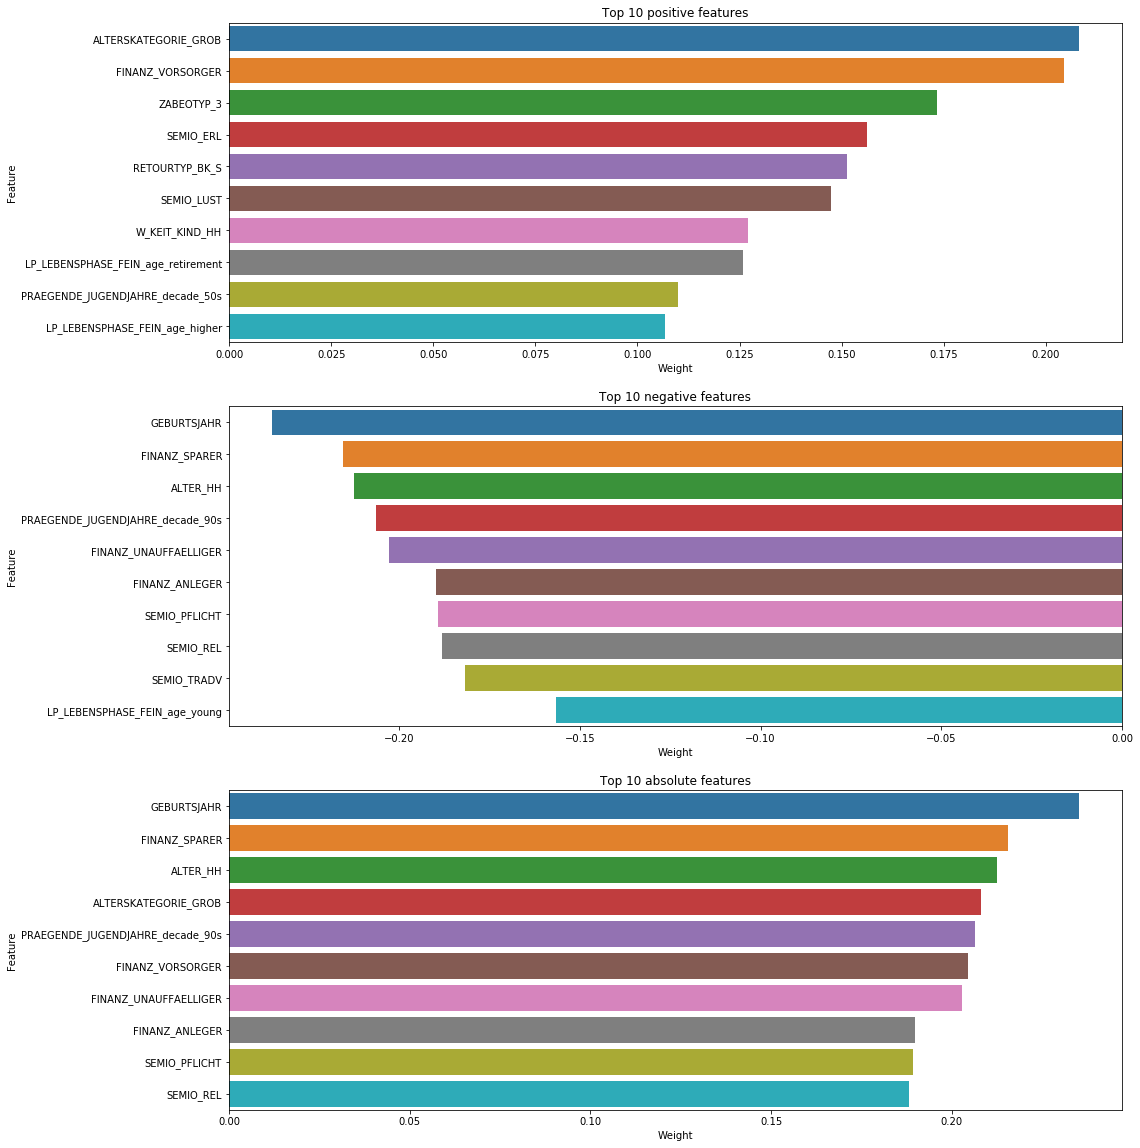

In [49]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

analyze_component(azdias_mod, pca, 1, top=10)

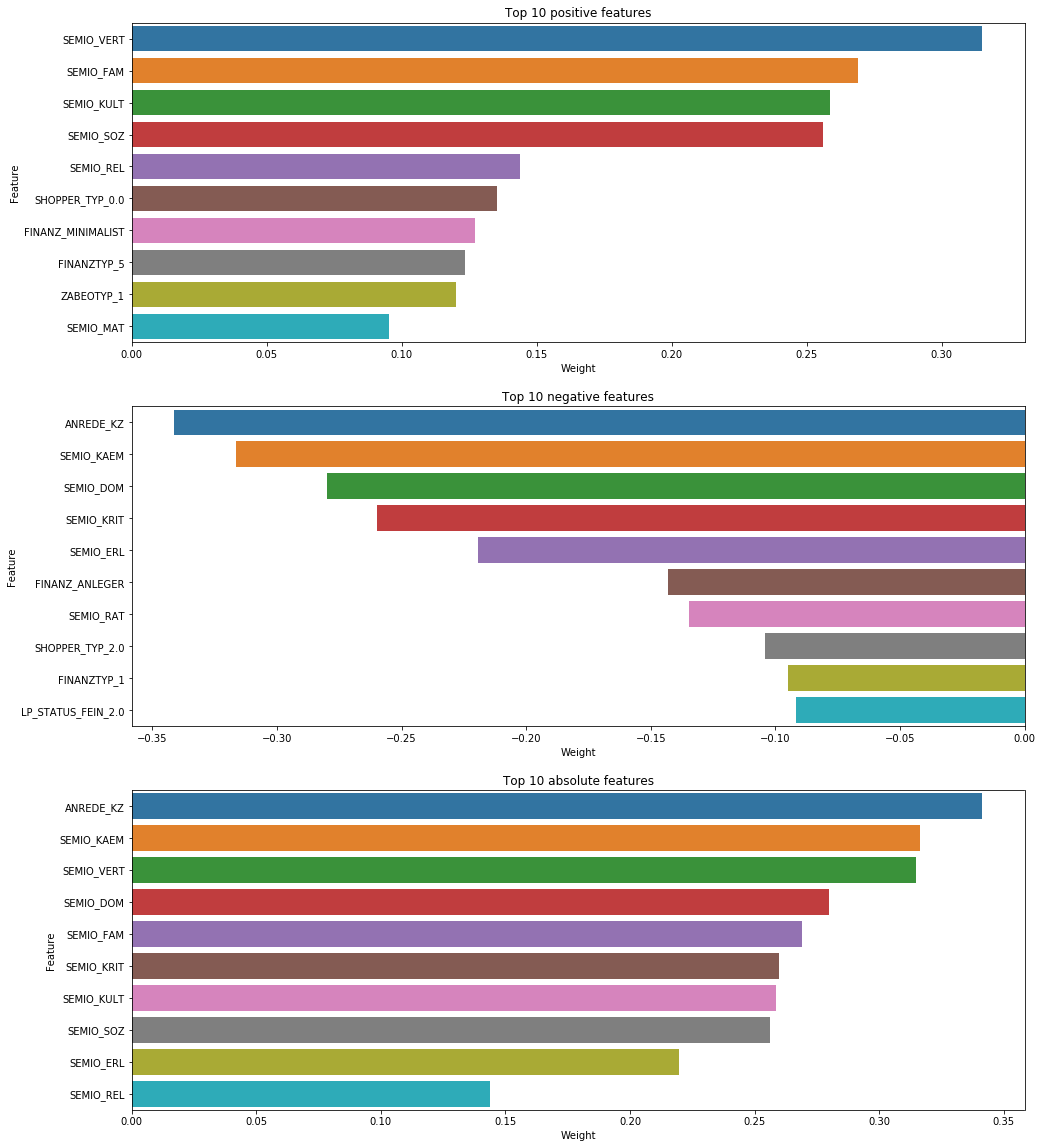

In [50]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

analyze_component(azdias_mod, pca, 2, top=10)

### Discussion 2.3: Interpret Principal Components

* First principle component's top positive features are about income, family size and savings. One can suspect, that the larger families low income `LP_LEBENSPHASE_FEIN_income_low` or just income `HH_EINKOMMEN_SCORE`, then the bigger the family unit cell `PLZ8_ANTG3`, `PLZ8_ANTG4` in PLZ8 region and size of community `ORTSGR_KLS9`. ALso with increased income house ownership `FINANZ_HAUSBAUER` is also expect to increase. For the negative features, family unit size `KBA05_ANTG1` and building type ` KBA05_BAUMAX` for 1-2 decreases in KBA05 region. Hence, with increased income small family units are moving out of KBA05 regions. This is also suported by negative weight for movement `MOBI_REGIO`. I would say that the first principle component analysis the poorest and smallest families in the dataset- how their size and building type/region is affected by their income.  
* The dominant feature in second component is Year of Birth `GEBURTSJAHR`. With smaller value, i.e. the younger the person, less likely he is to save money `FINANZ_SPARER`. It is also very intuitive that the younger the person, the yourger is birthdate of household `ALTER_HH`. This might indicate that people tend to move out of their places and don't live with their older perents. Anti-correlation between positive `ALTERSKATEGORIE_GROB` estimated age based on given name analysis and negative `GEBURTSJAHR` Year of Birth, simply shows the younger person will have larger birth date value, but smaller age value. Postive `FINANZ_VORSORGER` shows that will age person becomes more prepared to save money. ALso, it seems like older people become indiferent to energy (positive `ZABEOTYP` Energy consumption typology). All in all, second priciple component analysis age affects on persons savings and energy consumption (young people have short term view on finance but long term on energy consumption).
* The third principle component is basically about personality typology `SEMIO` and gender `ANREDE_KZ` (gender having the largest weight). Even without analysing individually each personality dimension, we can suspect that personalities are strongly related to genders. Increase in `ANREDE_KZ` can be associated to person being female, while decrease - male, because females were encoded as 2, while males as 1. Being more "male" (decrease in `ANREDE_KZ`) means that person is more combative `SEMIO_KAEM`, more dominant minded `SEMIO_KAEM`, more critical minded `critical-minded`, because smaller `SEMIO` points indicates higher affinity. For being more female (increase in `ANREDE_KZ`) means mroe dreamy `SEMIO_VERT`, family minded `SEMIO_FAM`, more culturally minded `SEMIO_KULT` and more socially minded `SEMIO_SOZ`. Interestingly this component is the most straight forward to interprent, even though it accounts for only 3.18% of all variance.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [53]:
%%time

# Over a number of different cluster counts...
centroids = [10, 15, 20, 25, 30]
k_scores = list()
for c in centroids:

    # run k-means clustering on the data and...
    kmeans = KMeans(c)
    model = kmeans.fit(azdias_mod_ss_pca)
    
    # compute the average within-cluster distances on random samples of data
    scores = list()
    for _ in range(10000):
        azdias_sample = azdias_mod_ss_pca[np.random.choice(azdias_mod_ss_pca.shape[0], 10000, replace=False), :]
        k_s = kmeans.score(azdias_sample)
        scores.append(abs(k_s))
    k_scores.append(scores)  

# for ploting
centroids = ["KMean_"+str(_) for _ in centroids]

Wall time: 53min 12s


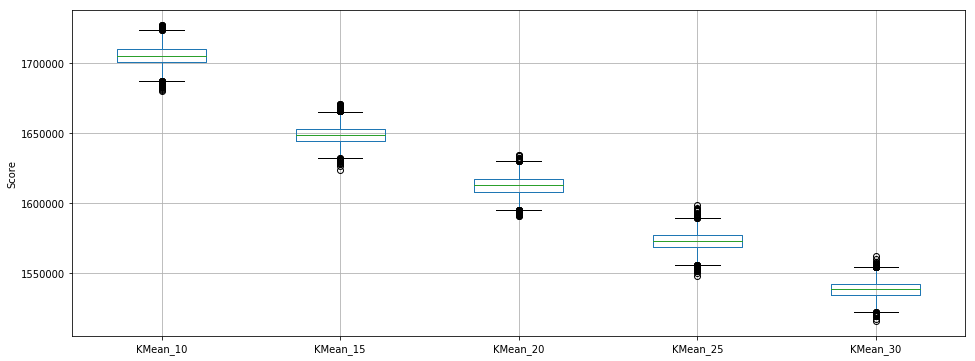

In [64]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

df_temp = pd.DataFrame(np.array(k_scores).T, columns= centroids)
df_temp.boxplot(figsize=(16, 6))
plt.ylabel("Score");

In [51]:
%%time

# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(20)
model = kmeans.fit(azdias_mod_ss_pca)

Wall time: 5min 18s


### Discussion 3.1: Apply Clustering to General Population

I found an idea online (https://stats.stackexchange.com/questions/11691/how-to-tell-if-data-is-clustered-enough-for-clustering-algorithms-to-produce-m) how one can randomly sample part of data then measure score and compare score distributions vs number of clusters. In my case no double slope decrease was observed when using different number of K Means (just straight line), i.e. increase in 1 Kmean has same effect on decrease on average distance between points. Therefore, I just chose arbitary number of KMeans= 20. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [52]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", delimiter=";")

In [53]:
%%time
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_mod = clean_data(customers, feat_info)

CJT_GESAMTTYP        feature one-hot-encoded
FINANZTYP            feature one-hot-encoded
GFK_URLAUBERTYP      feature one-hot-encoded
LP_FAMILIE_FEIN      feature one-hot-encoded
LP_STATUS_FEIN       feature one-hot-encoded
NATIONALITAET_KZ     feature one-hot-encoded
SHOPPER_TYP          feature one-hot-encoded
SOHO_KZ              feature one-hot-encoded
VERS_TYP             feature one-hot-encoded
ZABEOTYP             feature one-hot-encoded
KK_KUNDENTYP         feature one-hot-encoded
GEBAEUDETYP          feature one-hot-encoded
OST_WEST_KZ          feature one-hot-encoded
CAMEO_DEU_2015       feature one-hot-encoded
PRAEGENDE_JUGENDJAHRE feature processed
CAMEO_INTL_2015      feature processed
LP_LEBENSPHASE_FEIN  feature processed
WOHNLAGE             feature processed
KBA05_BAUMAX         feature processed
PLZ8_BAUMAX          feature processed
Wall time: 10min 35s


In [54]:
# add extra collumn with 0 values, because customer data didn't had single entry of GEBAEUDETYP_5.0
GEBAEUDETYP_5 = pd.Series(0, index=np.arange(customers_mod.shape[0]))
# make sure you inser it at the right lcoation
customers_mod.insert(131, "GEBAEUDETYP_5.0", GEBAEUDETYP_5)

In [55]:
# remove all rows which contain atleast one nan value
customers_mod_no_nan = customers_mod.dropna()
# create new dataframe using scaller
customers_mod_ss = pd.DataFrame(scaler.transform(customers_mod_no_nan), columns = customers_mod.columns.values)

C:\Users\Tomas\PycharmProjects\nano_degree_DS\venv\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [56]:
# transfort to fited PCA
customers_mod_ss_pca = pca.transform(customers_mod_ss)

In [167]:
# get labels with fitted KMeans model
azdias_labels = kmeans.predict(azdias_mod_ss_pca)
customer_labels = kmeans.predict(customers_mod_ss_pca) 

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [153]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# create dataframes with cluster labels for Azdias and customers
azdias_Kmeans = pd.DataFrame(azdias_labels, columns=["Label"])
customer_Kmeans = pd.DataFrame(customer_labels, columns=["Label"])
azdias_size = azdias_labels.shape[0]
customer_size = customer_labels.shape[0]
# count clusters and join them in new dataframe
s1 = azdias_Kmeans["Label"].value_counts() / azdias_size
s2 = customer_Kmeans["Label"].value_counts() / customer_size
clusters_df = pd.DataFrame(dict(Azdias = s1, Customers = s2)).reset_index()
clusters_df = clusters_df.rename(columns={"index": "cluster"})

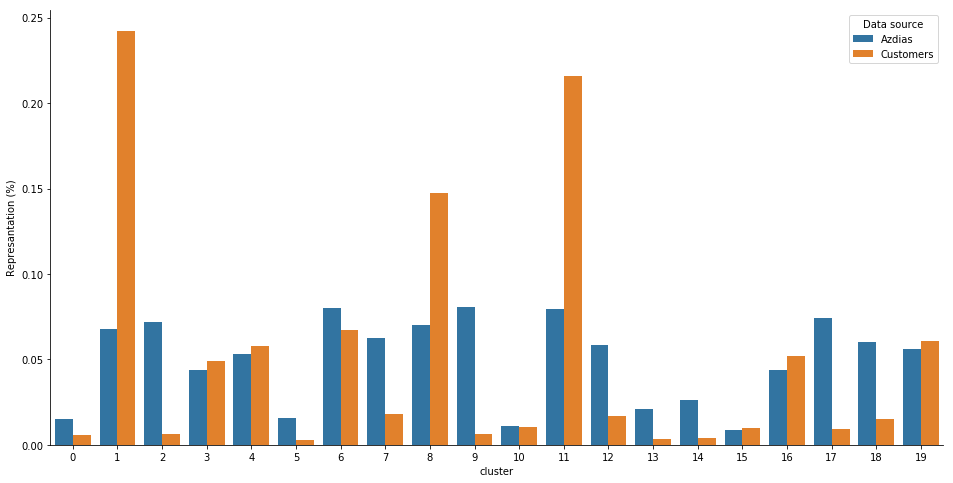

In [155]:
# visualize proportion
fig, ax1 = plt.subplots(figsize=(16, 8))
tidy = (
    clusters_df.set_index('cluster')
      .stack()  # un-pivots the data 
      .reset_index()  # moves all data out of the index
      .rename(columns={'level_1': 'Data source', 0: 'Represantation (%)'})
)
sns.barplot(x='cluster', y='Represantation (%)', hue='Data source', data=tidy, ax=ax1)
sns.despine(fig)

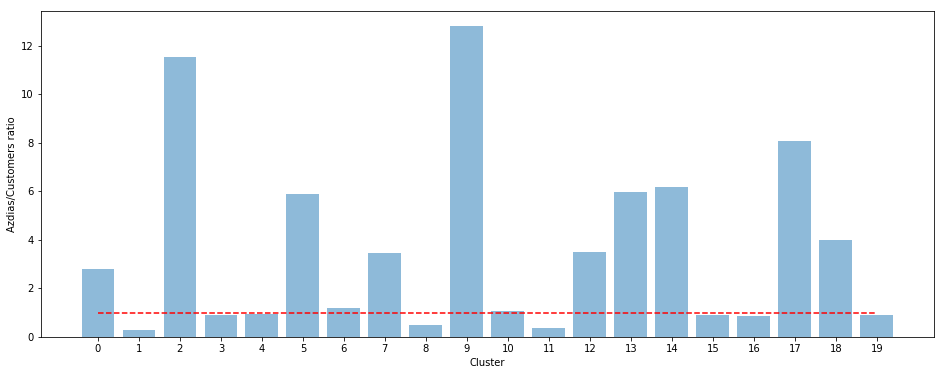

In [158]:
# check ratio
clusters_df["ratio"] = clusters_df["Azdias"] / clusters_df["Customers"]
plt.figure(figsize=(16, 6))
plt.bar(clusters_df.cluster.values, clusters_df.ratio.values, align='center', alpha=0.5);
plt.plot([0, 19], [1, 1], "r--")
plt.ylabel("Azdias/Customers ratio");
plt.xlabel("Cluster")
plt.xticks([x for x in range(20)]);

In [171]:
# inverse transform Kmean centers
centers = pca.inverse_transform(kmeans.cluster_centers_)

In [200]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# most overrepresented feature in customer data set is Clester #1
df_temp = pd.DataFrame(centers[1,:])
df_temp.columns= ["Weight"]
df_temp["Column_name"] = azdias_mod.columns.values
df_temp.nlargest(10, 'Weight')
# np.transpose(centers[1,:])

,Weight,Column_name
103,1.708798,LP_STATUS_FEIN_10.0
199,1.635393,LP_LEBENSPHASE_FEIN_type_multi
180,1.546197,PRAEGENDE_JUGENDJAHRE_movement
9,1.546197,GREEN_AVANTGARDE
204,1.496730,LP_LEBENSPHASE_FEIN_income_high
27,1.314669,ANZ_PERSONEN
92,1.123629,LP_FAMILIE_FEIN_10.0
2,1.052803,FINANZ_MINIMALIST
93,1.038829,LP_FAMILIE_FEIN_11.0
208,0.979710,LP_LEBENSPHASE_FEIN_age_middle


In [203]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# the most underrepresented feature in customer data set is Clester #1
df_temp = pd.DataFrame(centers[9,:])
df_temp.columns= ["Weight"]
df_temp["Column_name"] = azdias_mod.columns.values
df_temp.nlargest(10, 'Weight')

,Weight,Column_name
95,1.736702,LP_STATUS_FEIN_2.0
119,1.378070,ZABEOTYP_5
65,1.359899,FINANZTYP_1
3,1.267635,FINANZ_SPARER
186,1.242290,PRAEGENDE_JUGENDJAHRE_decade_90s
20,1.219861,SEMIO_RAT
210,1.103515,LP_LEBENSPHASE_FEIN_age_young
205,1.095080,LP_LEBENSPHASE_FEIN_income_low
8,1.050889,GEBURTSJAHR
5,1.045304,FINANZ_ANLEGER


### Discussion 3.3: Compare Customer Data to Demographics Data

* Clusters 1, 8 and 11 are overrepresented in customer dataset as compared to general population. After analysing the 1st cluster, it was shown that customer data overrepresents gerneral population with top earners living in multiperson families, i.e. have large, muligeration families amd had a membership in environmental sustainability as part of their youth. 
* Clusters 2, 9 and 17 are underrepresentd in customer dataset as compared to general population. After analysing the 9th cluster, it was shown that customer dataset lacks people who are young (from 90s) and low income earners, and who are seeking orientation in energy consumption by being investors with high savings. They are also rational.

Hance, it is older rich people who are interested in mailing list services. I guess young people don't see much value in paper mail anymore.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.